---


<h1 style="text-align:center"> 
Lung Cancer Classification using CT Data (Smoke Detector)
</h1><style>

---

- Constança Fernandes, nº202205398
- Daniela Osório, nº202208679
- Inês Amorim, nº2021108108
- Pedro Afonseca, nº202205394

---

## Introduction

> The integration of artificial intelligence (AI) into lung cancer screening represents a transformative approach to early detection and diagnosis, as lung cancer has a high mortality rate and many times it is diagnosed in the middle and late stages, when few therapies are available. The late diagnose happens beacause there are no obvious symptoms at an early stage **[2]**. With the ability to analyze complex medical data, AI enhances the identification of pulmonary nodules, ultimately improving patient outcomes. 

> Innovations such as low-dose computed tomography (LDCT) and computer-aided detection (CAD) systems enable precise characterization of nodules, facilitating personalized treatment strategies. As the field advances, ongoing research continues to explore the intersection of imaging techniques and AI, aiming to refine diagnostic processes and minimize the need for invasive procedures. **[1]**

--- 
## Libraries


In [1]:
import pandas as pd
import pylidc as pl
import xml.etree.ElementTree as ET
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from utils import get_malignancy_class, cluster_annots, get_cropped_annot
import pydicom
from radiomics import featureextractor
import SimpleITK as sitk
import os
import re
from pathlib import Path
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedGroupKFold, RandomizedSearchCV, cross_validate
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.compose import ColumnTransformer
from sklearn.metrics import make_scorer, precision_score, f1_score, RocCurveDisplay, roc_auc_score, fbeta_score, balanced_accuracy_score, recall_score, ConfusionMatrixDisplay
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.feature_selection import SelectFromModel
from imblearn.over_sampling import SMOTE
from typing import Tuple
from collections import defaultdict
from pathlib import Path

In [20]:
# Remove Warnings
import warnings
warnings.filterwarnings('ignore')

In [21]:
RESULTS = Path("results")

In [34]:
#pylidc must be in lung-cancer-classification directory
print(pl.__file__)

/home/inesamorim46/3ano1sem/labiacd/proj_1/lung-cancer-classification/pylidc/__init__.py


---

## Importing XML files

In [35]:
nodule_counts_df = pd.read_excel('lidc-idri-nodule-counts-6-23-2015.xlsx')
nodule_counts_df.head()

,TCIA Patent ID,Total Number of Nodules*,Number of Nodules >=3mm**,Number of Nodules <3mm***,Unnamed: 4,Unnamed: 5
0,LIDC-IDRI-0001,4,1,3,NaN,NaN
1,LIDC-IDRI-0002,12,1,11,NaN,*total number of lesions that received either ...
2,LIDC-IDRI-0003,4,4,0,NaN,"**total number of lesions that received a ""nod..."
3,LIDC-IDRI-0004,4,1,3,NaN,"***total number of lesions that received a ""no..."
4,LIDC-IDRI-0005,9,3,6,NaN,NaN


> We chose not to use the Excel file containing nodule counts because it lacks the important information necessary for our analysis. Specifically, the file does not provide essential details about the characteristics or context of the nodules, which are necessary for accurately assessing their implications for lung cancer diagnosis and treatment.

In [36]:
pacient_data_df = pd.read_excel('tcia-diagnosis-data-2012-04-20.xls')
pacient_data_df.head()

,TCIA Patient ID,"Diagnosis at the Patient Level\n0=Unknown\n1=benign or non-malignant disease\n2= malignant, primary lung cancer\n3 = malignant metastatic\n",Diagnosis Method\n0 = unknown\n1 = review of radiological images to show 2 years of stable nodule\n2 = biopsy\n3 = surgical resection\n4 = progression or response,Primary tumor site for metastatic disease,"Nodule 1\nDiagnosis at the Nodule Level \n0=Unknown\n1=benign or non-malignant disease\n2= malignant, primary lung cancer\n3 = malignant metastatic)\n",Nodule 1\nDiagnosis Method at the Nodule Level\n0 = unknown\n1 = review of radiological images to show 2 years of stable nodule\n2 = biopsy\n3 = surgical resection\n4 = progression or response\n,"Nodule 2\nDiagnosis at the Nodule Level \n0=Unknown\n1=benign or non-malignant disease\n2= malignant, primary lung cancer\n3 = malignant metastatic)\n",Nodule 2\nDiagnosis Method at the Nodule Level\n0 = unknown\n1 = review of radiological images to show 2 years of stable nodule\n2 = biopsy\n3 = surgical resection\n4 = progression or response\n,"Nodule 3\nDiagnosis at the Nodule Level \n0=Unknown\n1=benign or non-malignant disease\n2= malignant, primary lung cancer\n3 = malignant metastatic)\n",Nodule 3\nDiagnosis Method at the Nodule Level\n0 = unknown\n1 = review of radiological images to show 2 years of stable nodule\n2 = biopsy\n3 = surgical resection\n4 = progression or response\n,"Nodule 4\nDiagnosis at the Nodule Level \n0=Unknown\n1=benign or non-malignant disease\n2= malignant, primary lung cancer\n3 = malignant metastatic)\n",Nodule 4\nDiagnosis Method at the Nodule Level\n0 = unknown\n1 = review of radiological images to show 2 years of stable nodule\n2 = biopsy\n3 = surgical resection\n4 = progression or response\n,"Nodule 5\nDiagnosis at the Nodule Level \n0=Unknown\n1=benign or non-malignant disease\n2= malignant, primary lung cancer\n3 = malignant metastatic)\n",Nodule 5\nDiagnosis Method at the Nodule Level\n0 = unknown\n1 = review of radiological images to show 2 years of stable nodule\n2 = biopsy\n3 = surgical resection\n4 = progression or response\n
0,LIDC-IDRI-0068,3,4,Head & Neck Cancer,3.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,LIDC-IDRI-0071,3,1,Head & Neck,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,LIDC-IDRI-0072,2,4,Lung Cancer,1.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,LIDC-IDRI-0088,3,0,Uterine Cancer,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,LIDC-IDRI-0090,2,3,NSCLC,2.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [37]:
print(pacient_data_df.shape)

(157, 14)


> We decided not to use the Excel file containing patient data from previous scans and cancers due to its limited scope, as it only includes information for about 10% of the patients studied. 

---


## Importing and Handling Annotations

> Although extracting features from CT Scans using Radiomics and Neural Networks provides information that is not yet seen by humans at first sight, most of the researchers don't believe these methods will replace the radiologists' role. Instead, using expert-reviwed data enhances the reliability of the features obtained, leading to better clinical outcomes **[3]**. Having this into account, it is still relevant to use the annotations features.


> As was done in **[4]**, the nodule annotations were used to obtain a consensus, where each feature is the average of the level assigned by each radiologist, rounded to the nearest integer. 


> The code used to obtain this dataset is written and explained  in **'process_anns.ipynb'**.

> To see the process done to obtain this dataframe, please see document **"process_anns.ipynb"**

In [38]:
df_annotations = pd.read_csv('annotations_ds.csv', index_col=0)
df_annotations 

,ID,Scan_ID,Patient_ID,Texture,Spiculation,Lobulation,Margin,Sphericity,Calcification,Internal Structure,Subtlety,Malignancy
0,2,1,LIDC-IDRI-0078,5,2,2,3,4,6,1,4,4
1,1,1,LIDC-IDRI-0078,4,2,3,3,4,6,1,5,4
2,8,1,LIDC-IDRI-0078,5,1,1,5,5,5,1,4,1
3,3,1,LIDC-IDRI-0078,5,3,3,3,4,5,1,5,4
4,16,2,LIDC-IDRI-0069,5,4,4,4,4,6,1,2,3
...,...,...,...,...,...,...,...,...,...,...,...,...
2656,6850,1016,LIDC-IDRI-0639,3,3,2,2,4,6,1,4,4
2657,6851,1016,LIDC-IDRI-0639,1,2,1,2,4,6,1,2,4
2658,6856,1017,LIDC-IDRI-0638,5,1,2,4,4,6,1,3,4
2659,6855,1017,LIDC-IDRI-0638,5,1,1,5,4,6,1,5,2


---


###  Analysing Class Distribution from Data Extracted from Annotations

array([<Axes: ylabel='Frequency'>, <Axes: ylabel='Frequency'>,
       <Axes: ylabel='Frequency'>, <Axes: ylabel='Frequency'>,
       <Axes: ylabel='Frequency'>, <Axes: ylabel='Frequency'>,
       <Axes: ylabel='Frequency'>, <Axes: ylabel='Frequency'>,
       <Axes: ylabel='Frequency'>], dtype=object)

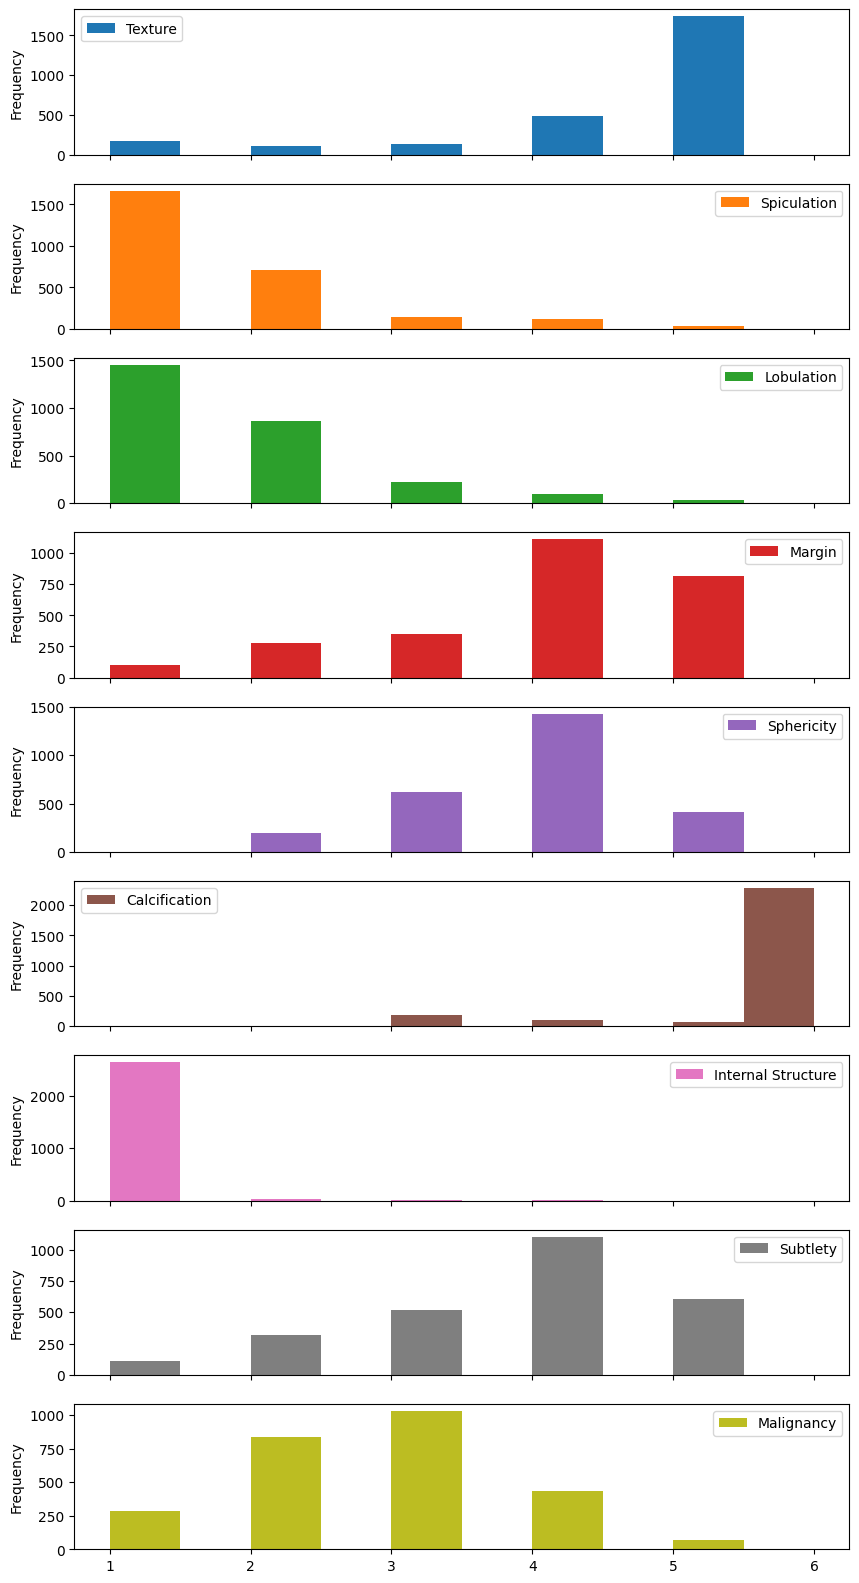

In [39]:
df_annotations.drop(["ID", "Scan_ID", "Patient_ID"], axis=1).plot(kind="hist", subplots=True, figsize=(10, 20))

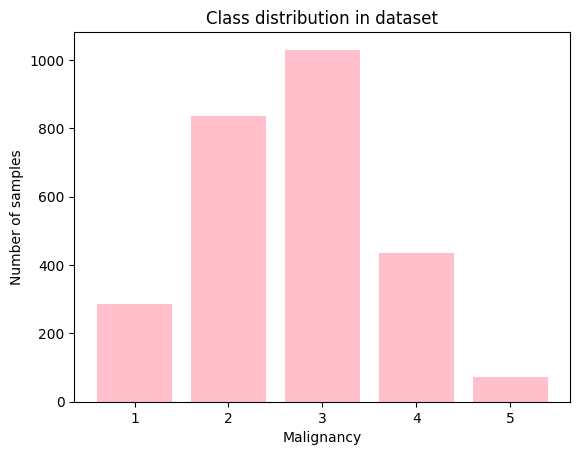

In [40]:
unique_labels, counts = np.unique(df_annotations["Malignancy"], return_counts=True)
plt.bar(unique_labels, counts, color='pink')
plt.xlabel("Malignancy")
plt.ylabel("Number of samples")
plt.title("Class distribution in dataset")
plt.show()

The first two categories have similar, high counts of samples (around 1000).

The third category has a significantly lower number of samples, around 500, indicating a potential imbalance.

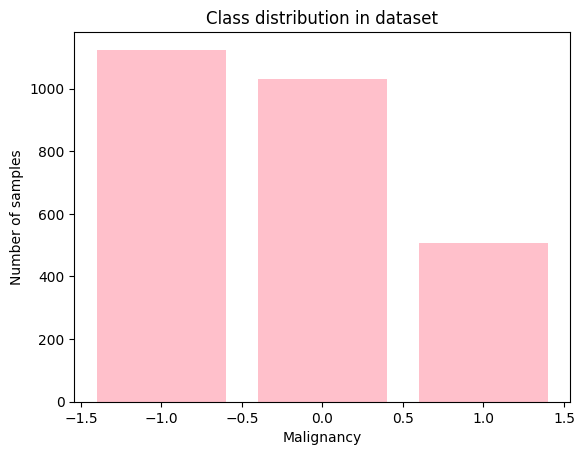

In [42]:
df_annotations["class"] = df_annotations["Malignancy"].apply(get_malignancy_class)

unique_labels, counts = np.unique(df_annotations["class"], return_counts=True)
plt.bar(unique_labels, counts, color='pink')
plt.xlabel("Malignancy")
plt.ylabel("Number of samples")
plt.title("Class distribution in dataset")
plt.show()

1- Correlation with Malignancy:

- Spiculation, Lobulation and Calcification appear to have the strongest positive correlations with "Malignancy," suggesting that as the values of these features increase, the likelihood of malignancy also increases.
- Margin shows a relatively strong negative correlation with "Malignancy," meaning that higher calcification is associated with benign characteristics (lower malignancy probability).
- Subtlety has weaker correlation with "Malignancy" compared to "Spiculation" and "Lobulation," but still shows some association.

2. Other Notable Relationships:

- Spiculation and Lobulation are positively correlated with each other, which may indicate that nodules with high spiculation also tend to exhibit lobulated edges.
- Texture and Internal Structure have weak correlations with most other features, implying that they may not be as predictive for malignancy.

<Axes: >

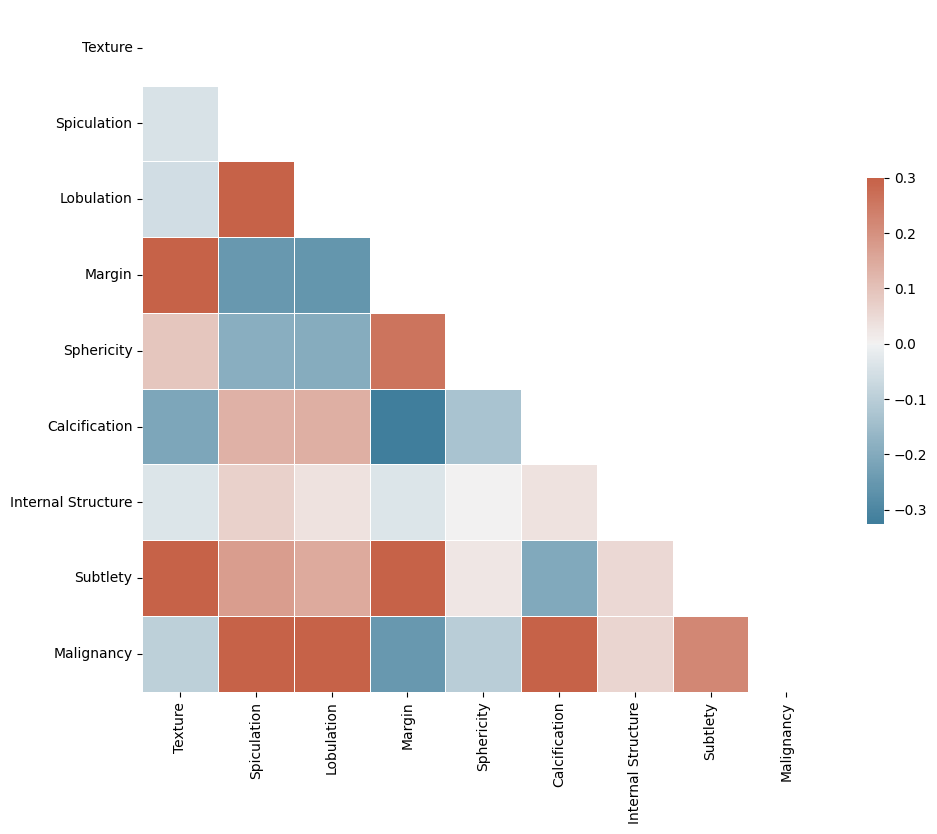

In [42]:
# Compute the correlation matrix
corr = df_annotations.drop(["ID", "Scan_ID", "Patient_ID", "class"], axis=1).corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

---

## Feature Extraction from CT Scans

These features describe various properties of the image, such as texture, shape, inetnsity, and spatial relationships, which may not be visible to the naked eye

### 1. Radiomics

> To see the process done to obtain the extracted features through *pyradiomics*, please see document **"process_radiomics.ipynb"**

In [2]:
df_radiomics = pd.read_csv('radiomics.csv')
df_radiomics

,Unnamed: 0,original_shape_Elongation,original_shape_Flatness,original_shape_LeastAxisLength,original_shape_MajorAxisLength,original_shape_Maximum2DDiameterColumn,original_shape_Maximum2DDiameterRow,original_shape_Maximum2DDiameterSlice,original_shape_Maximum3DDiameter,original_shape_MeshVolume,...,original_glszm_ZoneEntropy,original_glszm_ZonePercentage,original_glszm_ZoneVariance,original_ngtdm_Busyness,original_ngtdm_Coarseness,original_ngtdm_Complexity,original_ngtdm_Contrast,original_ngtdm_Strength,Patient_ID,ID
0,0,0.823485,0.422484,3.597711,8.515614,8.062258,9.848858,10.049876,10.246951,139.958333,...,1.000000e+00,0.013514,5329.0,0.181343,1.392715,0.009703,0.000078,1.165431,LIDC-IDRI-0848,5523
1,1,0.822030,0.332701,5.249749,15.779186,19.026298,18.248288,15.000000,19.052559,747.750000,...,-3.203427e-16,0.001312,0.0,0.000000,1000000.000000,0.000000,0.000000,0.000000,LIDC-IDRI-0159,1338
2,2,0.737988,0.325554,2.055999,6.315384,5.099020,7.071068,7.071068,7.141428,39.541667,...,-3.203427e-16,0.022222,0.0,0.000000,1000000.000000,0.000000,0.000000,0.000000,LIDC-IDRI-0159,1339
3,3,0.594263,0.285487,14.952101,52.373975,45.177428,48.836462,56.515485,63.419240,9251.583333,...,1.298795e+00,0.000861,9426162.0,2.276169,0.110029,0.001955,0.000002,0.101741,LIDC-IDRI-0829,5630
4,4,0.935982,0.601938,4.003552,6.651108,7.280110,8.062258,7.211103,8.124038,110.583333,...,-3.203427e-16,0.008547,0.0,0.000000,1000000.000000,0.000000,0.000000,0.000000,LIDC-IDRI-0830,5627
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2656,2656,0.612233,0.352484,2.305650,6.541145,4.123106,7.280110,7.000000,7.348469,31.833333,...,-3.203427e-16,0.027027,0.0,0.000000,1000000.000000,0.000000,0.000000,0.000000,LIDC-IDRI-0201,1700
2657,2657,0.789584,0.411954,2.864976,6.954600,8.000000,8.544004,6.082763,8.544004,74.750000,...,-3.203427e-16,0.012346,0.0,0.000000,1000000.000000,0.000000,0.000000,0.000000,LIDC-IDRI-0201,1702
2658,2658,0.871072,0.394275,2.357012,5.978092,6.082763,6.403124,6.082763,7.280110,44.291667,...,-3.203427e-16,0.020000,0.0,0.000000,1000000.000000,0.000000,0.000000,0.000000,LIDC-IDRI-0201,1699
2659,2659,0.824329,0.585070,6.185429,10.572110,9.848858,12.649111,12.529964,12.649111,393.375000,...,-3.203427e-16,0.002481,0.0,0.000000,1000000.000000,0.000000,0.000000,0.000000,LIDC-IDRI-0676,6581


### 2. CNN

> To see the process done to obtain the extracted features through *cnn's*, please see document **"cnn_feature_extractor.ipynb"**

#### Deep Features

In [3]:
df_cnn_deep = pd.read_csv("cnn_deep.csv")
df_cnn_deep

,Unnamed: 0,cnn_0,cnn_1,cnn_2,cnn_3,cnn_4,cnn_5,cnn_6,cnn_7,cnn_8,...,cnn_23,cnn_24,cnn_25,cnn_26,cnn_27,cnn_28,cnn_29,cnn_30,cnn_31,ID
0,0,1.241468,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.066853,0.990587,...,0.285106,0.231232,0.0,0.625406,0.000000,0.000000,2.069331,0.0,0.547192,102
1,1,0.000000,1.232410,0.000000,1.063928,1.120160,0.0,0.828725,0.000000,0.000000,...,0.000000,0.915816,0.0,0.000000,1.252468,1.223173,0.000000,0.0,0.000000,103
2,2,0.000000,1.342468,0.043411,1.226732,1.113360,0.0,0.763096,0.000000,0.000000,...,0.000000,1.023974,0.0,0.000000,1.148508,0.987634,0.000000,0.0,0.000000,109
3,3,0.000000,0.861694,0.000000,0.798592,0.769274,0.0,0.557115,0.000000,0.000000,...,0.000000,0.719021,0.0,0.000000,0.775924,0.684797,0.000000,0.0,0.000000,116
4,4,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.050138,0.157876,0.077221,...,0.055109,0.156057,0.0,0.350073,0.027086,0.081437,0.373397,0.0,0.256892,123
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2656,2665,0.000000,0.410857,0.000000,0.335077,0.382398,0.0,0.308489,0.000000,0.000000,...,0.000000,0.321696,0.0,0.000000,0.511903,0.479820,0.000000,0.0,0.000000,4519
2657,2666,0.000000,1.975172,0.000000,1.593027,1.804445,0.0,1.260259,0.000000,0.000000,...,0.000000,1.312931,0.0,0.000000,1.857454,1.895398,0.000000,0.0,0.000000,4522
2658,2667,0.000000,1.506138,0.102357,1.392534,1.253237,0.0,0.868991,0.000000,0.000000,...,0.000000,1.167139,0.0,0.000000,1.263877,1.108913,0.000000,0.0,0.000000,4524
2659,2668,0.000000,1.338855,0.000000,1.193478,1.151428,0.0,0.795956,0.000000,0.000000,...,0.000000,0.996575,0.0,0.000000,1.185952,1.080413,0.000000,0.0,0.000000,4526


#### Pre-trained Model Features

In [4]:
df_cnn_pre_trained = pd.read_csv("cnn_pretrained.csv")
df_cnn_pre_trained

,Unnamed: 0,pca0,pca1,pca2,pca3,pca4,pca5,pca6,pca7,pca8,...,pca191,pca192,pca193,pca194,pca195,pca196,pca197,pca198,pca199,ID
0,0,-28.862408,3.752524,-12.629104,3.694289,-3.617787,8.736332,2.377903,-2.257868,-12.693306,...,-0.475949,1.763081,-1.035181,0.129095,-1.971602,-1.417496,1.054354,0.349048,1.423461,102
1,1,10.284248,4.924620,-2.747968,-1.245035,-1.307115,1.780016,1.354484,-2.506646,3.570466,...,0.145580,-0.639781,-0.347615,-0.030194,0.080013,0.045747,0.513203,0.225490,-1.190453,103
2,2,8.985373,2.576475,0.109423,1.403091,-0.456045,0.923358,1.409719,1.615725,1.140846,...,-0.668258,-0.268869,0.791192,0.386122,0.175140,-0.042782,-0.682645,-0.879624,0.164075,109
3,3,7.977247,1.219759,1.210066,1.638670,-1.578279,-3.928095,1.803608,1.403588,-1.157376,...,-0.500650,0.258099,-0.181931,0.919360,0.235270,0.274724,1.416356,1.671143,-0.680947,116
4,4,-9.503909,-11.624536,2.111700,-4.423035,2.308307,0.628816,-5.473779,-2.100862,2.955586,...,0.988510,0.783137,-2.684016,0.540568,1.012633,0.173970,-0.242350,-1.454935,-0.304751,123
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2656,2665,6.878442,-1.322916,4.547146,5.457790,-0.543405,-4.435112,0.193059,5.457479,-3.327473,...,-0.470241,0.106813,-0.258970,-0.153676,-0.229152,0.078406,0.096592,-0.089086,-0.842193,4519
2657,2666,9.652906,3.155041,-0.060737,1.592898,2.945357,0.978017,1.330562,1.024554,1.152521,...,-0.050992,0.103570,0.485398,-0.188950,-0.292568,-0.181481,0.069825,0.102156,-0.105623,4522
2658,2667,11.231087,6.418330,-4.255191,-2.717045,-1.276963,-0.961450,-0.396524,-0.489676,-1.044307,...,-0.382508,-0.191141,0.039196,0.245216,0.109593,0.064033,-0.036009,0.288020,0.139713,4524
2659,2668,10.449172,4.864744,-2.176744,0.034756,-1.147599,0.108293,0.323538,1.584202,0.433010,...,-0.298237,0.171113,-0.479163,0.759911,-0.227797,-0.082521,-0.283985,0.149991,-0.475655,4526


#### Shallow Features

In [5]:
df_cnn_shallow = pd.read_csv("cnn_shallow.csv")
df_cnn_shallow

,Unnamed: 0,pca0,pca1,pca2,pca3,pca4,pca5,pca6,pca7,pca8,...,pca191,pca192,pca193,pca194,pca195,pca196,pca197,pca198,pca199,ID
0,0,18.507799,-3.979196,-1.464212,-8.249301,-1.511281,-0.097843,-1.964366,6.425084,-9.777150,...,-0.188038,-0.287847,0.185013,-0.304888,0.635551,-0.320602,0.520961,-0.050294,-0.329315,102
1,1,-4.250829,-1.281081,0.436666,-1.098827,-0.974764,1.090660,-0.674656,-2.024909,-1.488662,...,0.039800,-0.048407,0.035358,-0.130424,-0.079888,0.016756,-0.102583,0.092161,0.098691,103
2,2,-4.975577,-3.055070,-1.504835,0.237379,0.371976,-0.352268,-0.019358,0.190688,0.163588,...,0.084992,-0.060501,0.078606,-0.048059,0.063553,0.045959,-0.048258,-0.075211,0.088765,109
3,3,-4.693306,-2.727945,-1.592518,0.335238,0.449730,-0.929249,0.105895,0.085130,0.382369,...,0.115303,0.037878,-0.017470,-0.163283,0.129294,0.011924,-0.003593,0.015148,-0.098916,116
4,4,5.008068,7.774472,2.010175,-2.677969,2.351102,1.659552,-4.834831,-0.240802,0.664957,...,0.022431,0.093454,0.228445,-0.153856,0.190015,0.393490,-0.188809,-0.054659,0.534190,123
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2656,2665,-4.011442,-1.228873,-0.360800,0.251840,0.875796,-0.516059,-0.572818,1.275961,0.857650,...,0.012727,0.015679,-0.091654,-0.069153,0.017380,-0.128829,0.069251,0.048517,0.107039,4519
2657,2666,-3.893099,-0.133541,1.890239,-0.115855,-0.775877,1.852403,1.224801,0.510861,0.487906,...,-0.080948,-0.032327,-0.176588,-0.020396,0.049191,0.115357,0.083434,-0.025168,-0.052190,4522
2658,2667,-4.934571,-2.952329,-1.358606,0.087699,0.100700,-0.197082,0.062460,-0.235171,-0.063018,...,-0.066094,-0.096277,0.054241,0.145780,0.010509,-0.064955,0.052617,-0.009317,-0.026682,4524
2659,2668,-4.570329,-2.025797,-0.370149,-0.301723,-0.198063,0.454411,-0.254986,-0.278002,-0.388061,...,-0.163988,0.189690,-0.078068,-0.073425,-0.070037,0.058576,0.060794,0.068982,0.032420,4526


### 3. Sound

> To see the process done to obtain the extracted features through *sound*, please see document **"process_dicom.ipynb"**

In [6]:
df_sound = pd.read_csv('sound.csv')
df_sound

,Unnamed: 0,onset_density,ZCR,energia total,dynamic_range,max_amp,min_amp,mean_amp,ff,centroid_mean,bandwidth_mean,tempo,num_onset,mean_ioi,variance_ioi,ID
0,0,0.497801,127333175,90.308733,32767,1,20833.326869,1295.57,5566.717143,3510.192856,161.499023,150,0.098958,0.003393,10.173167,1338
1,1,0.497630,73059890,90.308733,32767,1,20834.284890,1196.93,4406.960035,3436.754457,206.718750,68,0.111941,0.008106,9.066612,1339
2,2,0.497730,551525482,90.308733,32767,1,20832.898835,2524.62,6012.193588,3448.115361,143.554688,426,0.159262,0.014823,6.293753,5630
3,3,0.496403,59409632,90.308733,32767,1,20830.733166,1279.99,4559.221271,3538.758582,105.468750,89,0.084964,0.002002,11.903448,5627
4,4,0.496233,55088763,90.308733,32767,1,20832.581357,2084.03,7743.259086,3205.973971,105.468750,93,0.075086,0.001464,13.462776,5628
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2681,1222,0.497267,195706414,90.308733,32767,1,20833.786156,1597.67,6657.358305,3416.003831,129.199219,273,0.080886,0.001754,12.408579,4482
2682,1223,0.496336,393252983,90.308733,32767,1,20830.328123,1431.05,5048.883787,3376.017725,82.031250,383,0.098806,0.003541,10.147298,4483
2683,1224,0.497931,229372374,90.308733,32767,1,20833.947822,1186.47,5081.419418,3519.292184,112.347147,176,0.143831,0.008988,6.992332,4484
2684,1225,0.498215,64993158,90.308733,32767,1,20832.664431,1376.39,4129.192106,3382.617581,103.359375,103,0.076148,0.001199,13.261106,4491


---

## Binary vs Multiclass Classification

Studies have explored both binary and multiclass classification approaches for lung cancer detection, each with its own advantages, but both reasonable options.

> **Binary Classification** typically focuses on distinguishing between bening and malignant, making it simpler and often more efficient in clinical settings. 

> In contrast, **Multiclass Classification** can provide deeper insights into various lung cancer subtypes, which can inform treatment strategies. Research shows that multiclass models can enhance diagnostic accuracy by capturing the complexity of tumor presentations, although they may require larger datasets and more sophisticated algorithms. Apart from this, a multiclass classification can lead to a smaller number of false negatives and can give insight on which treatment to use. **[5]**

We chose to use Binary Classification, as our main goal is to categorize lung nodules into malignant and non-maligant categories and we found more studies than not that used this approach. However, using Multiclass Classification could be a work for the future.

---

## Data Cleaning

### 1. Nodule Classification Ajustment

Because we opted for Binary Classification, we need to reduce the 5 existing categories into 2. There are many ways to do this, some better that others.

> The general idea between studies that use this type of classification is to is to categorize the malignancy values below 3 (i.e, 1 and 2) as **benign** and the values above 3 (i.e, 4 and 5) as **malign**. In this case, the nodules with malignancy value of 3 are eliminated.

> Another option is to, instead of excluding the nodules with malignancy value of 3, includes these in the category of malignant, so there is not a loss in data. Assigning them as malignant is always better that to assigning them as the opposotive, as in medicine is considered worst to have a false-negative than a false-positive.

### 2. Treating Class Imbalance

In [47]:
df_annotations["class"] = df_annotations["Malignancy"].apply(get_malignancy_class)
unique_labels, counts = np.unique(df_annotations["class"], return_counts=True)
print(f"Malignant Samples: {counts[2]}")
print(f"Benign Samples: {counts[0]}")

Malignant Samples: 507
Benign Samples: 1124


As we see, because we decided to use binary classification, we ended up with more than a two-time difference between the number of malignant samples and benign samples. 

- SMOTE

> A good way to treat this problem is by using SMOTE, an oversampling mthod that generates synthetic samples for the minority class (in this case, the 'malignant' class) by interpolating between existing samples. When compared to simple oversampling (that duplicates existing examples), this method introduces variability. This is applied during the training preparation process and can be seen in the subsection **'Hyperparameter Tunning'**

---

## Training Preparation

> In our analysis, we will utilize XGBoost and Random Forest as our primary machine learning algorithms. These algorithms are particularly well-suited for our dataset, which comprises over 100 features extracted from the LIDC-IDRI dataset. The goal is to compare the performance of the 3.

- **XGBoost** is known for its high performance and efficiency in handling large datasets with many features, as it employs a gradient boosting framework that optimizes model training.
- **Random Forest** provides an ensemble learning approach, combining multiple decision trees to enhance predictive accuracy while also allowing us to assess feature importance through its built-in measures.

### 1. Merge CSVs

In [8]:
# Function to merge CSV files
def merge_csvs(csv_list):
    # Load the first CSV
    merged_df = pd.read_csv(csv_list[0], index_col=0)
    
    # Merge the remaining CSVs
    for csv in csv_list[1:]:
        temp_df = pd.read_csv(csv, index_col=0)
        temp_df.drop("Patient_ID", axis=1, inplace=True, errors="ignore")
        merged_df = merged_df.merge(temp_df, on="ID")
    
    return merged_df

### 2. Split Datasets

A common pitfalls when evaluating and testing a classification model for potential lung nodule malignancy is not considering the nodules of the same patient to be completely separated into the training set or the validation set **[4]**.

In [9]:
def split_dataset(df: pd.DataFrame) -> Tuple[pd.DataFrame, pd.DataFrame]:
    # Step 1: Get unique patient_ids
    unique_patients = df['Patient_ID'].unique()

    # Step 2: Split unique patient_ids
    train_patients, test_patients = train_test_split(unique_patients, test_size=0.2, random_state=42)

    # Step 3: Filter original dataset based on the split patient_ids
    train_set = df[df['Patient_ID'].isin(train_patients)]
    test_set = df[df['Patient_ID'].isin(test_patients)]
    return train_set, test_set

In [10]:
def prepare_df(merged_df):
    merged_df = merged_df[merged_df["Malignancy"] != 3] # Remove Indeterminate malignancy
    merged_df.loc[merged_df["Malignancy"] < 3, "Malignancy"] = 0
    merged_df.loc[merged_df["Malignancy"] > 3, "Malignancy"] = 1

    train_set, test_set = split_dataset(merged_df)

    # Define features and target
    X_train = train_set.drop(columns=["ID", "Scan_ID", "Patient_ID", "Malignancy"])  # Exclude "ID", "Scan_ID", "Patient_ID" and "Malignancy" from features
    y_train = train_set["Malignancy"]  # Target variable
    groups_train = train_set["Patient_ID"]

    X_test = test_set.drop(columns=["ID", "Scan_ID", "Patient_ID", "Malignancy"])  # Exclude "ID", "Scan_ID", "Patient_ID" and "Malignancy" from features
    y_test = test_set["Malignancy"]  # Target variable

    return X_train, y_train, groups_train, X_test, y_test

### 3. Hyperparameter Tunning

We used the **RandomizedSearchCV** method, that allows for randomized sampling of hyperparameters to optimize the machine learning method.
The function accepts a classifier, a set of hyperparameter distributions to search over, the input data X and labels y, and a name for the model.

> **Preprocessing:**

- To address the class imbalance in our dataset, we used **Synthetic Minority Over-sampling Technique (SMOTE)** to create a more balanced distribution between malignant and benign cases. This disparity can pose significant challenges for machine learning models, which may become biased towards predicting the majority class, in this case, benign cases, leading to reduced sensitivity in detecting malignancies.

- We created a **ColumnTransformer**, which applies **StandardScaler()** to scale the numeric features. This is crucial, especially for algorithms sensitive to feature scaling like XGBoost.

- **Principal Component Analysis (PCA)** is applied to features extracted from Convolutional Neural Networks (CNNs) primarily to address the issue of dimensionality, which arises due to the high volume of features generated by these networks. High-dimensional data can lead to several issues including overfitting. By applying PCA, we reduce the feature space to a more manageable size while retaining the most informative aspects of the data.

- We used **Linear Support Vector Classification (LinearSVC)** for feature selection because some features in our dataset may not significantly contribute to the classification task and may introduce noise, making it harder for the model to learn the key patterns needed for accurate classification. This will not always be used and we rely on random parameter search to determine if this step is done or skiped.

> **Pipeline Setup:** We created a pipeline that consists of the preprocessing steps and the classifying step.

> **Cross-Validation:** We used **StratifiedKFold** cross-validation, which splits the data into 5 folds while ensuring that the distribution of classes remains balanced in each fold.

> **RandomizedSearchCV:** The next step is to perform hyperparameter tuning by randomly selecting hyperparameter combinations from the provided **param_distributions**.

> **Fitting the Model and Displaying Results:** After the tuning process and the fitting of each model, the function prints the best hyperparameters and the highest AUC score achieved during cross-validation.

In [11]:
# Function to perform RandomizedSearchCV
def tune_model(classifier, param_distributions, X, y, groups, model_name, pca_components=200, n_iter=80):
    #Synthetic Oversampling
    smote = SMOTE(random_state=42)
    X_resampled, y_resampled = smote.fit_resample(X, y)

    # Define the preprocessor (if needed)
    # Here, we"ll standardize the numeric features
    numeric_features = [col for col in X.select_dtypes(include=["float64", "int64"]).columns]
    cnn_features = [col for col in X.columns if col.startswith("cnn_")]
    
    if pca_components > 0:
        pca = ColumnTransformer(transformers=[
                ("pca", PCA(n_components=pca_components), cnn_features), # Use pca for cnn features
            ],
            remainder="passthrough",
            verbose_feature_names_out=False,
        )
    else:
        pca = "passthrough"

    scaler = ColumnTransformer(transformers=[
            ("num", StandardScaler(), numeric_features),  # Standardize numeric features
        ],
        remainder="passthrough",
    )

    # Create the pipeline
    pipeline = Pipeline(steps=[
        ("pca", pca),                # PCA step
        ("scaler", scaler),          # Scaling step
        ("feature_selection", "passthrough"), # Feature selector
        ("classifier", classifier),  # Classifier passed as parameter
    ]).set_output(transform="pandas")

    # Setup StratifiedKFold cross-validation
    kf = StratifiedGroupKFold(n_splits=5, shuffle=True, random_state=42)

    # Metrics
    scoring = {
        "recall": make_scorer(recall_score),
        "precision": make_scorer(precision_score),
        "f1_score": make_scorer(f1_score),
        "f2_score": make_scorer(fbeta_score, beta=2),
        "balanced_accuracy": make_scorer(balanced_accuracy_score),
        "auc": make_scorer(roc_auc_score, response_method="predict_proba"),
    }

    # Setup RandomizedSearchCV
    random_search = RandomizedSearchCV(
        pipeline,
        param_distributions,
        n_iter=n_iter,  # Number of random combinations to try
        scoring=scoring,
        refit="recall",  # Use recall as the scoring metric
        cv=kf,
        random_state=42,
        n_jobs=-1,  # Use all available cores
        # return_train_score=True,
        # error_score='raise',
    )

    # Perform RandomizedSearchCV
    groups_resampled = pd.concat([groups, pd.Series([f"smoted-{i}" for i in range(len(X_resampled)- len(X))])])
    random_search.fit(X_resampled, y_resampled, groups=groups_resampled)

    # Display the best parameters and score
    print(f"{model_name} - Best parameters: {random_search.best_params_}")
    print(f"{model_name} - Best Recall score: {random_search.best_score_:.4f}")

    return random_search

In [12]:
# Calculate feature importance for forest classifiers
def plot_feature_importance(estimator, feature_names, n_top=5, n_bottom=5):
    # Get the relevant steps
    forest = estimator.named_steps['classifier']
    feature_selector = estimator.named_steps['feature_selection']

    if not isinstance(feature_selector, str):
        # Get the boolean mask of selected features
        selected_features_mask = feature_selector.get_support()

        feature_names = feature_names[selected_features_mask]

    importances = forest.feature_importances_
    std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)

    forest_importances = pd.DataFrame({ "importance": importances, "std": std }, index=feature_names)

    if len(forest_importances) > n_top + n_bottom:
        # Get the highest values
        top = forest_importances.nlargest(5, "importance")

        # Get the lowest values
        bottom = forest_importances.nsmallest(5, "importance")

        # Combine the results
        forest_importances = pd.concat([top, bottom])

    fig, ax = plt.subplots()
    forest_importances["importance"].plot.bar(yerr=forest_importances["std"], ax=ax)
    ax.set_title("Feature importances using MDI")
    ax.set_ylabel("Mean decrease in impurity")
    fig.tight_layout()
    return importances, std

In [13]:
def get_scores(cv_results: dict, best_index: int):
    """
    Extracts scores of the best estimator from the cv_results
    and stores them in a easier format for later use
    """
    scores = {}
    for key, values in cv_results.items():
        if re.match("^split._test_", key):
            metric_name = key.split('_')[2]  # Extract the metric name (e.g., "recall")
            
            # Initialize the metric entry in the results dictionary if not present
            if metric_name not in scores:
                scores[metric_name] = []
            
            scores[metric_name].append(values[best_index])

    return pd.DataFrame(scores)

In [14]:
# Plot Roc Curve, Bar plot of metrics and Confusion Matrix
def plot_metrics(models, X_test, y_test):
    _, ax = plt.subplots()
    for name, pipeline in models:
        RocCurveDisplay.from_estimator(pipeline, X_test, y_test, ax=ax, name=name)
    plt.title("ROC Curve")
    plt.show()

    metrics = defaultdict(list)
    names = []
    for name, pipeline in models:
        names.append(name)
        preds = pipeline.predict(X_test)

        metrics["precision"].append(precision_score(y_test, preds))
        metrics["f1_scores"].append(f1_score(y_test, preds))
        metrics["f2_scores"].append(fbeta_score(y_test, preds, beta=2))
        metrics["balanced_accuracy"].append(balanced_accuracy_score(y_test, preds))
        metrics["aucs"].append(roc_auc_score(y_test, pipeline.predict_proba(X_test)[:, 1]))

    plt.figure(figsize=(15, 10))
    for i, column in enumerate(metrics.keys()):
        plt.subplot(2, 3, i + 1)
        plt.bar(names, metrics[column])
        plt.ylabel("scale")
        plt.title(column)
        plt.ylim(bottom=0.65)
    plt.show()

    plt.figure(figsize=(12, 5))
    for i, (name, pipeline) in enumerate(models):
        ax = plt.subplot(2, 3, i + 1)
        plt.title(name)
        ConfusionMatrixDisplay.from_estimator(pipeline, X_test, y_test, ax=ax)
    plt.plot()

###  XGBoost (xgb_param_distributions): 


- **n_estimators:** Number of boosting rounds or trees to grow, with values ranging from 50 to 300 in steps of 50.
- **max_depth:** Maximum depth of each tree, which controls the complexity of the model, sampled between 3 and 15.
- **learning_rate:** The step size at each iteration, ranging from 0.01 to 0.2 to control the contribution of each tree.
- **subsample:** Fraction of samples to be used in each boosting round, with values of 0.5, 0.7, and 1.0.
- **colsample_bytree:** Fraction of features used when building each tree, with values of 0.5, 0.7, and 1.0.
- **gamma:** Minimum loss reduction required to make a further partition in a leaf node, ranging from 0 to 5 in steps of 0.5.
- **feature_selection:** Whether to use feature selection or not.

In [15]:
# Parameter distributions for each classifier
xgb_param_distributions = {
    "classifier__n_estimators": np.arange(50, 300, 50),
    "classifier__max_depth": np.arange(3, 15),
    "classifier__learning_rate": [0.01, 0.05, 0.1, 0.2],
    "classifier__subsample": [0.5, 0.7, 1.0],
    "classifier__colsample_bytree": [0.5, 0.7, 1.0],
    "classifier__gamma": np.arange(0, 5, 0.5),
    "feature_selection": [SelectFromModel(LinearSVC(penalty="l1", max_iter=2000)), "passthrough"],
}

### Random Forest (rf_param_distributions):

- **n_estimators:** Number of trees in the forest, sampled between 50 and 300 in steps of 50.
- **max_depth:** Maximum depth of each tree, sampled between 3 and 15.
- **min_samples_split:** Minimum number of samples required to split an internal node, with options of 2, 5, and 10.
- **min_samples_leaf:** Minimum number of samples required to be at a leaf node, with values of 1, 2, and 4.
- **max_features:** The number of features to consider when looking for the best split, with options "auto" and "sqrt".
- **feature_selection:** Whether to use feature selection or not.

In [16]:
rf_param_distributions = {
    "classifier__n_estimators": np.arange(50, 300, 50),
    "classifier__max_depth": np.arange(3, 15),
    "classifier__min_samples_split": [2, 5, 10],
    "classifier__min_samples_leaf": [1, 2, 4],
    "classifier__max_features": ["log2", "sqrt"],
    "feature_selection": [SelectFromModel(LinearSVC(penalty="l1", max_iter=2000)), "passthrough"],
}

---

## Performance Metrics

For our binary classification task, we used a set of performance metrics to evaluate the models' ability to correctly classify benign and malignant nodules. Here are the ones we found to be the most interesting and valuable:

1. **F1-Score:**  This balances **Precision** and **Recall**, providing a harmonic mean between the two. It is especialle useful when the dataset has imbalanced classes as it gives a good balance between false positives and false negatives.

$$
F1 = 2 \times \frac{\text{Precision} \times \text{Recall}}{\text{Precision} + \text{Recall}}
$$

2. **F2-Score:** This is a variation of the F1-score that gives more weight to the **Recall** when compared to the Precision. This is especially important in the medical field, where minimizing false negatives is crucial, because failing to detect a malignant nodule can have severe consequences.

$$
F2 = 5 \times \frac{\text{Precision} \times \text{Recall}}{4 \times \text{Precision} + \text{Recall}}
$$

3. **Precision:** Measures how many of the predicted postives are actually postives, in this case, it is used to ensure that the predictions marked as malignant are actually malignant.

$$
\text{Precision} = \frac{TP}{TP + FP}
$$

4. **Recall (Sensitivity):**  Focuses on how well the model identifies actuall positives. A high recall ensures that most malignant nodules are detected.


$$
\text{Recall} = \frac{TP}{TP + FN}
$$

5. **ROC AUC:** The Are Under Curve is used to measure the overall models' ability to distinguish between classes, as the ROC Curve plots the true positive rate against the false positive rate. AUC is a value between 0 and 1, where 1 indicates perfect classification and 0.5 represents random guessing.

6. **Balanced Accuracy:** This is the average of recall for both classes (benign and malignant), making it particularly useful when dealing with imbalanced datasets. It ensures that both classes are treated equally, avoiding bias towards the more frequent class. As we've seen before there is more cases of non-malignant nodules.

$$
\text{Balanced Accuracy} = \frac{1}{2} \left( \frac{TP}{TP + FN} + \frac{TN}{TN + FP} \right)
$$

---

## Training Results

### 1. Annotations (Baseline)

In [57]:
merged_df = merge_csvs(["annotations_ds.csv"])
X_train, y_train, groups_train, X_test, y_test = prepare_df(merged_df)

In [58]:
# Tune models
ann_xgb_search = tune_model(XGBClassifier(eval_metric="mlogloss"), xgb_param_distributions, X_train, y_train, groups_train, "XGBoost")
ann_xgb = get_scores(ann_xgb_search.cv_results_, ann_xgb_search.best_index_)
ann_rf_search = tune_model(RandomForestClassifier(random_state=42), rf_param_distributions, X_train, y_train, groups_train, "Random Forest")
ann_rf = get_scores(ann_rf_search.cv_results_, ann_rf_search.best_index_)

XGBoost - Best parameters: {'feature_selection': 'passthrough', 'classifier__subsample': 0.7, 'classifier__n_estimators': 150, 'classifier__max_depth': 13, 'classifier__learning_rate': 0.2, 'classifier__gamma': 0.0, 'classifier__colsample_bytree': 0.7}
XGBoost - Best Recall score: 0.8617
Random Forest - Best parameters: {'feature_selection': 'passthrough', 'classifier__n_estimators': 200, 'classifier__min_samples_split': 2, 'classifier__min_samples_leaf': 1, 'classifier__max_features': 'sqrt', 'classifier__max_depth': 12}
Random Forest - Best Recall score: 0.8685


In [60]:
ann_xgb.to_csv(RESULTS/"ann_xgb.csv")
ann_rf.to_csv(RESULTS/"ann_rf.csv")

This plot displays feature importances in a model for detecting lung nodules.

1. **Spiculation**: This feature has the highest importance. Spiculation refers to irregular, spiky edges on a nodule, often associated with malignancy. The high importance suggests that nodules with speculated margins are more likely to be identified as cancerous.

2. **Subtlety**: This feature also has high importance. It typically measures how easily visible the nodule is. Malignant nodules may have distinct visual characteristics, so high subtlety could indicate features important for malignancy prediction.

3. **Lobulation**: Lobulated nodules, with lobe-like projections or uneven surfaces, are also associated with malignancy. Its importance here aligns with its relevance in distinguishing malignant nodules.

4. **Calcification**: Calcification within nodules can sometimes indicate benign characteristics, depending on its pattern. Its moderate importance might reflect this diagnostic nuance.

5. **Texture**: Texture describes the appearance (smooth or rough) of the nodule. Though texture is less important than speculation, it still contributes to the model, as rougher textures can sometimes indicate malignancy.

6. **Margin and Sphericity**: These features are less important here. While margins can indicate malignancy based on how well-defined or irregular they are, it seems less critical in this model. Sphericity, or the roundness of the nodule, is often less indicative on its own but could still play a minor role.

7. **Internal Structure**: This feature shows minimal importance, possibly because internal characteristics might not contribute significantly compared to external shape factors in malignancy prediction.

In summary, the model seems to prioritize irregular and speculated edges, visibility (subtlety), and lobulated shapes when identifying nodules likely to be malignant.

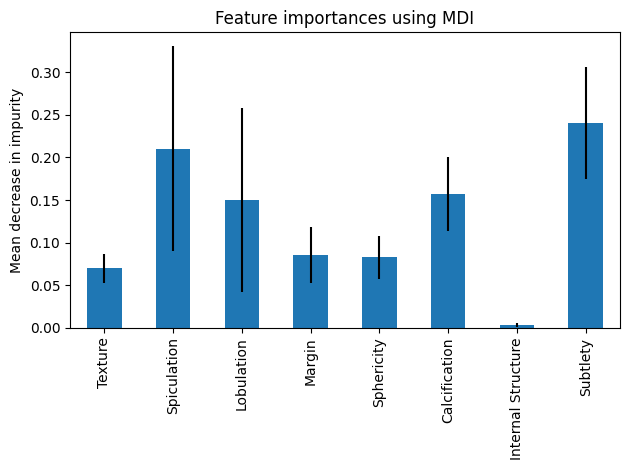

In [61]:
feature_names = X_train.columns
_ = plot_feature_importance(ann_rf_search.best_estimator_, feature_names)

The ROC (Receiver Operating Characteristic) curve presented here compares the True Positive Rate (sensitivity) against the False Positive Rate for two models, **XGBoost** and **Random Forest**, in classifying lung nodule malignancy. The AUC (Area Under the Curve) values provide insight into the overall performance of these models in distinguishing between malignant and benign nodules.

#### Analysis:

1. **AUC Values**:
   - **Random Forest**: AUC = 0.90
   - **XGBoost**: AUC = 0.89
   - Both models show high AUC values, with Random Forest performing marginally better. AUC values close to 1 indicate strong discriminatory power, meaning the models are effective at distinguishing malignant from benign nodules.
   - The small difference (0.01) between Random Forest and XGBoost implies they perform similarly, with Random Forest having a slight edge in overall accuracy across all threshold levels.

2. **Interpretation of the ROC Curve Shape**:
   - Both curves initially rise steeply, indicating high true positive rates at low false positive rates. This steep ascent is desirable, as it means the models achieve good sensitivity (true positive rate) without many false positives, an important aspect in medical diagnostics where minimizing false positives is beneficial.
   - After the initial steep rise, the curves flatten, indicating diminishing returns on sensitivity with an increase in false positives. This flattening is typical as the threshold is adjusted to higher values, where it becomes harder to maintain high sensitivity without compromising specificity.

3. **Threshold Selection**:
   - The ROC curve’s shape can inform optimal threshold selection, especially if specific clinical guidelines demand balancing sensitivity and specificity. For instance, if minimizing false negatives (high sensitivity) is a priority, the threshold can be set to a point where the True Positive Rate is maximized, though this may increase false positives slightly.
   - Both models perform consistently across thresholds, giving flexibility for different clinical scenarios, whether prioritizing sensitivity or specificity.

4. **Clinical Relevance**:
   - In lung nodule malignancy detection, a high AUC is crucial as it indicates that the models are reliable in distinguishing malignant from benign cases. This reliability is essential to minimize missed malignant cases, allowing for timely and accurate diagnosis.
   - The slight advantage of Random Forest (AUC = 0.90) might make it preferable if the objective is purely discriminatory power across varying thresholds.

#### Summary:

- Both **Random Forest** and **XGBoost** perform well, with AUC values close to 0.9, indicating strong model capability in distinguishing malignant from benign nodules.
- The marginally higher AUC for Random Forest suggests a slight advantage, but both models are suitable for applications where high sensitivity and flexibility in threshold adjustments are valuable.
- In a clinical setting, either model would be robust enough for nodule malignancy classification, but **Random Forest** might be chosen for its marginally higher AUC if discrimination is the priority. However, both models provide strong performance, and the choice may also consider other operational factors, such as computational efficiency or ease of interpretation.

1. **Precision**:
   - Both models have relatively high precision, with Random Forest performing slightly better than XGBoost. High precision indicates that when the models classify a nodule as malignant, they are very likely to be correct, resulting in fewer false positives.
   - This is important in a medical setting to avoid alarming patients with false malignancy results, reducing unnecessary anxiety and further testing.

2. **F1 Score**:
   - The F1 score balances precision and recall, providing a single measure of overall accuracy, with Random Forest having an edge.
   - The relatively high F1 scores indicate that both models handle the trade-off between detecting malignant nodules accurately (recall) and ensuring that benign nodules are not misclassified as malignant (precision).

3. **F2 Score**:
   - The F2 score places more weight on recall than precision. Here, Random Forest outperforms XGBoost again, which may indicate that Random Forest is somewhat better at minimizing false negatives.
   - In this medical context, a higher F2 score is particularly valuable because it implies the model is more sensitive to malignant cases, reducing the risk of missing a malignancy. Detecting as many true malignant cases as possible is crucial, given the consequences of undiagnosed cancerous nodules.

4. **Balanced Accuracy**:
   - Both models have good balanced accuracy, with Random Forest again slightly outperforming XGBoost. Balanced accuracy takes both true positive and true negative rates into account, which is useful in cases of class imbalance (where one class may have fewer samples).
   - This metric shows that both models are effective across both malignant and benign classifications.

5. **AUC (Area Under the ROC Curve)**:
   - The AUC values for both models are high, showing decent ability to distinguish between malignant and benign nodules. AUC measures the model's performance across all classification thresholds, indicating the likelihood that a randomly chosen malignant nodule is ranked higher than a benign one.
   - A high AUC value is critical in a medical setting because it shows that the model performs well even when thresholds are adjusted. This flexibility allows clinicians to tailor the sensitivity of the model based on clinical requirements, balancing the risk of false positives and negatives according to patient and healthcare system needs.

#### Summary and Insights:

- **Random Forest** consistently outperforms XGBoost across all metrics, indicating it may be the better model for this task.
- **Robustness**: Both models demonstrate good precision, F1 score, balanced accuracy, and AUC.
- **Sensitivity to Malignancy**: The higher F2 score for Random Forest suggests it may be more reliable in identifying malignant nodules, which is crucial in a task where missing a malignancy can have severe implications.

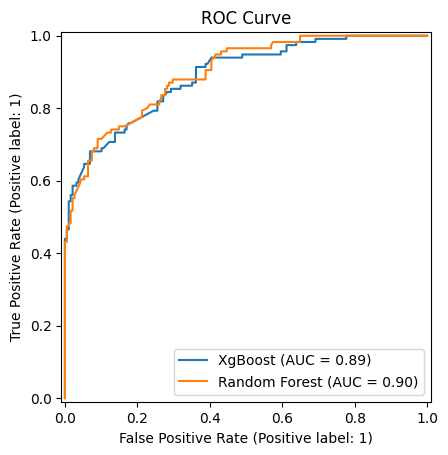

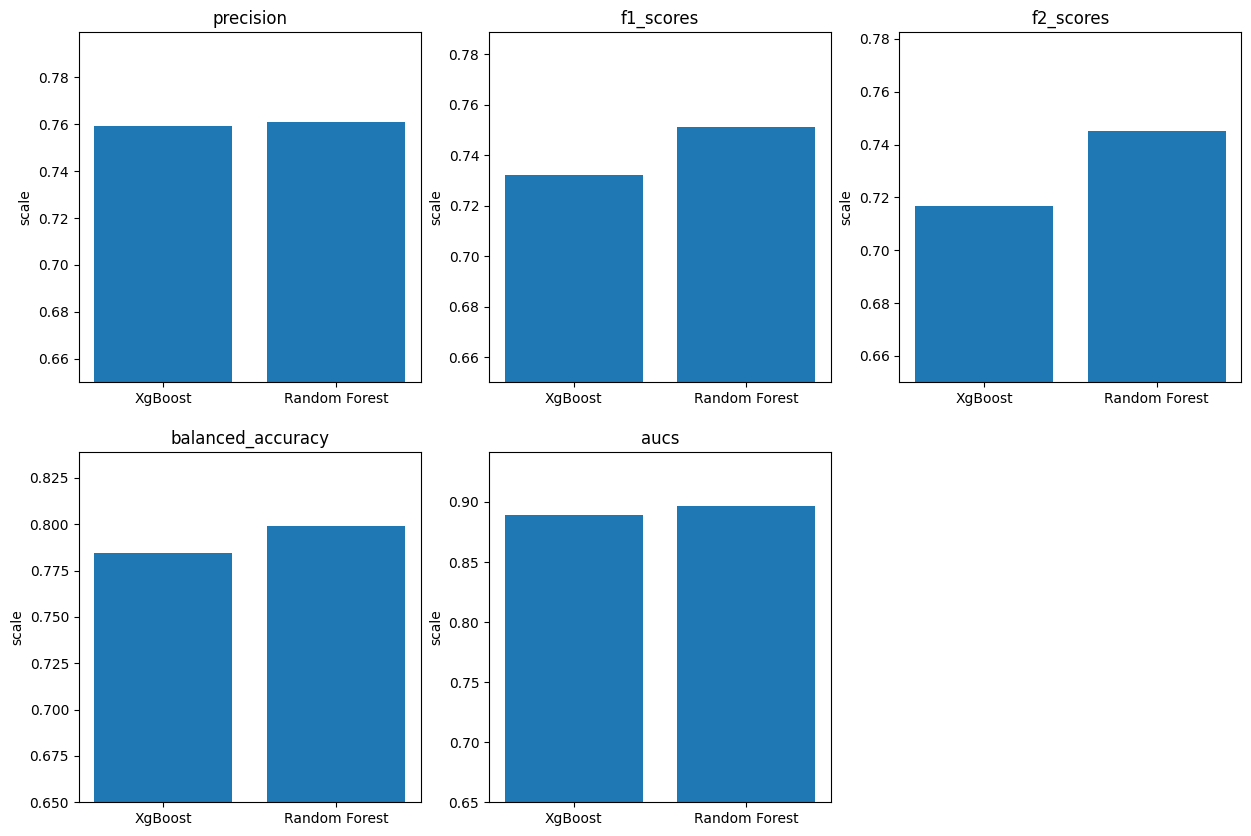

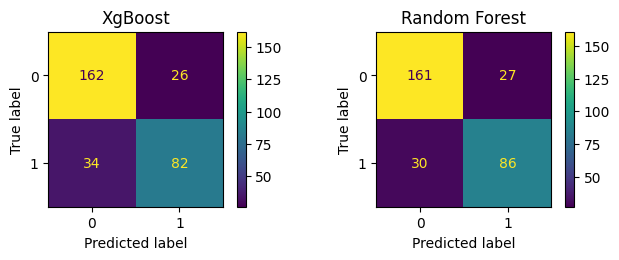

In [181]:
models = [
    ("XgBoost", ann_xgb_search.best_estimator_),
    ("Random Forest", ann_rf_search.best_estimator_),
]
plot_metrics(models, X_test, y_test)

### 2. Annotations + Radiomics

In [63]:
merged_df = merge_csvs(["annotations_ds.csv", "radiomics.csv"])
X_train, y_train, groups_train, X_test, y_test = prepare_df(merged_df)

In [64]:
# Tune models
ann_rad_xgb_search = tune_model(XGBClassifier(eval_metric="mlogloss"), xgb_param_distributions, X_train, y_train, groups_train, "XGBoost")
ann_rad_xgb = get_scores(ann_rad_xgb_search.cv_results_, ann_rad_xgb_search.best_index_)

ann_rad_rf_search = tune_model(RandomForestClassifier(random_state=42), rf_param_distributions, X_train, y_train, groups_train, "Random Forest")
ann_rad_rf = get_scores(ann_rad_rf_search.cv_results_, ann_rad_rf_search.best_index_)

XGBoost - Best parameters: {'feature_selection': SelectFromModel(estimator=LinearSVC(max_iter=2000, penalty='l1')), 'classifier__subsample': 0.7, 'classifier__n_estimators': 250, 'classifier__max_depth': 12, 'classifier__learning_rate': 0.1, 'classifier__gamma': 0.0, 'classifier__colsample_bytree': 0.5}
XGBoost - Best Recall score: 0.9302


Random Forest - Best parameters: {'feature_selection': 'passthrough', 'classifier__n_estimators': 250, 'classifier__min_samples_split': 2, 'classifier__min_samples_leaf': 1, 'classifier__max_features': 'sqrt', 'classifier__max_depth': 14}
Random Forest - Best Recall score: 0.9147


In [65]:
ann_rad_xgb.to_csv(RESULTS/"ann_rad_xgb.csv")
ann_rad_rf.to_csv(RESULTS/"ann_rad_rf.csv")

Due to the high number of features, only the top 5 and bottom 5 were included for clarity.

1. **Top Contributing Features**:
   - **original_gldm_DependenceNonUniformity**: This feature is derived from the Gray Level Dependence Matrix (GLDM) and measures non-uniformity in dependence values, capturing texture variation within the nodule. Higher dependence non-uniformity can indicate heterogeneity, which is often associated with malignancy.
   - **original_shape_MinorAxisLength**: This shape-based feature measures the minor axis length of the nodule, which might correlate with irregular growth patterns often seen in malignant nodules.
   - **original_glrlm_GrayLevelNonUniformity**: Derived from the Gray Level Run Length Matrix (GLRLM), this feature reflects texture non-uniformity. Higher non-uniformity can indicate irregular and potentially malignant textures within the nodule.
   - **original_shape_Maximum2DDiameterSlice**: This feature represents the maximum diameter of the nodule in a 2D slice. Malignant nodules tend to have larger and more irregular shapes, making this an important factor in malignancy prediction.
   - **original_shape_SurfaceArea**: This measures the surface area of the nodule, where larger, irregular surfaces might suggest malignancy due to irregular growth patterns.

   These top features contribute the most to model decisions, with texture and shape irregularities being highly influential in distinguishing between benign and malignant nodules.

2. **Less Contributing Features**:
   - **Internal Structure**: This feature has minimal importance in this plot, indicating that it may not contribute significantly to the model's performance. Internal structure alone might not differentiate well between malignant and benign nodules.
   - **original_glszm_HighGrayLevelZoneEmphasis**: This feature from the Gray Level Size Zone Matrix (GLSZM) measures the concentration of high gray levels. It might capture some intensity characteristics but shows lower importance, possibly because other texture features offer more precise indicators of malignancy.
   - **original_glcm_imc2 and original_glcm_idn**: These features are from the Gray Level Co-occurrence Matrix (GLCM) and capture spatial relationships between gray levels. Their lower importance here may imply that specific spatial relationships in gray levels do not strongly influence malignancy classification.
   - **original_glszm_SizeZoneNonUniformity**: This GLSZM-based feature measures non-uniformity in zone sizes but appears to have limited influence in this model.

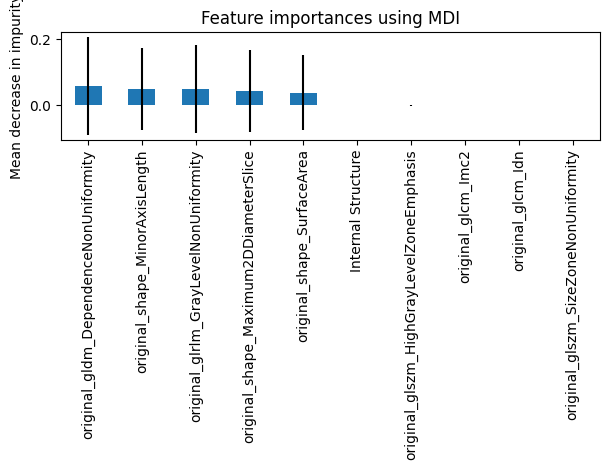

In [66]:
feature_names = X_train.columns
_ = plot_feature_importance(ann_rad_rf_search.best_estimator_, feature_names)

- **XGBoost** consistently shows a slight edge across all metrics compared to Random Forest, indicating it may be the slightly better model.
- **Robustness**: Both models demonstrate high precision, F1 score, balanced accuracy, and AUC.
- **Sensitivity to Malignancy**: The higher F2 score for XGBoost suggests it may be more reliable in identifying malignant nodules.

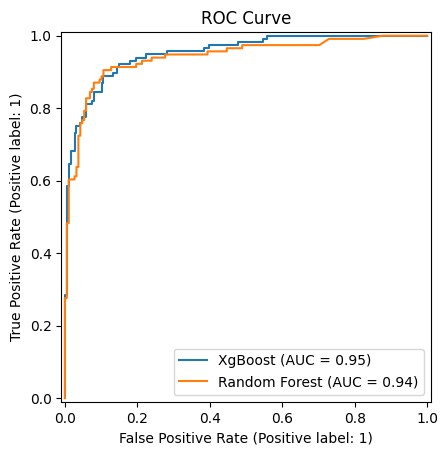

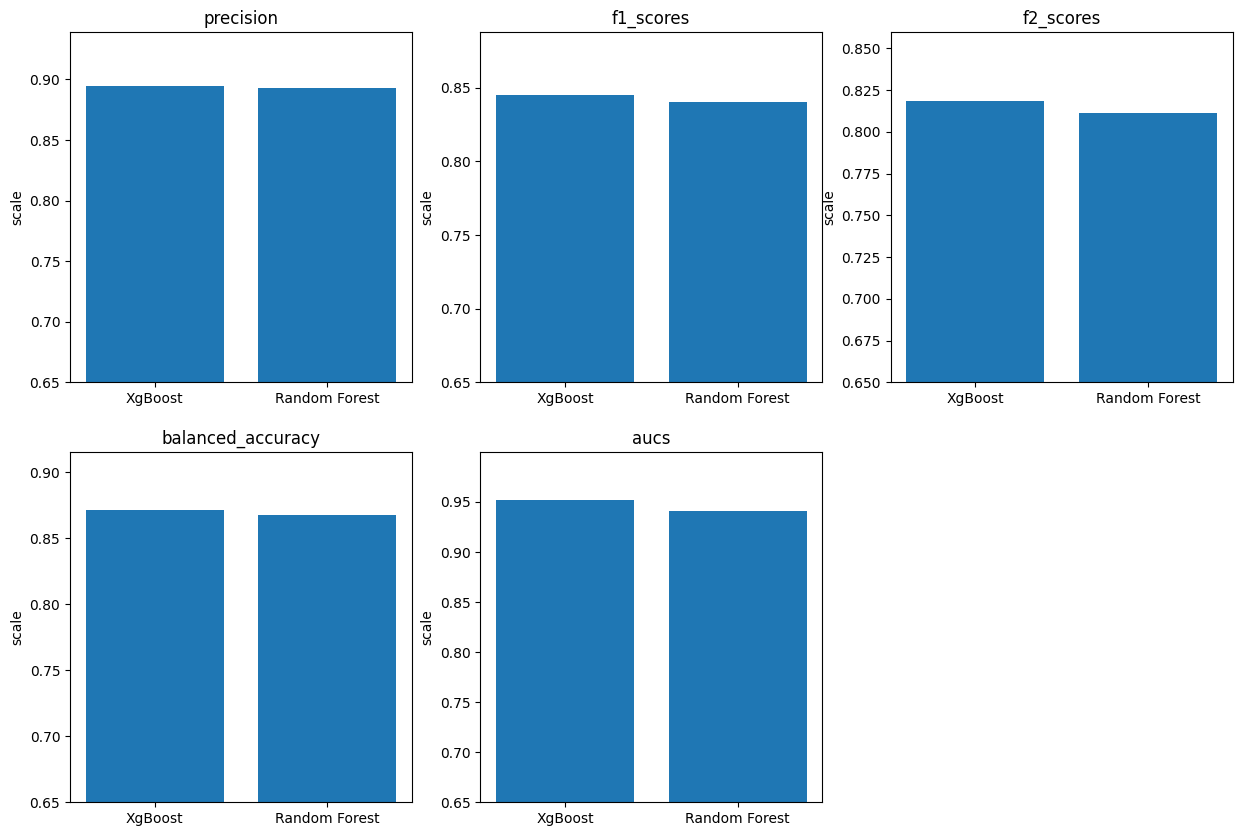

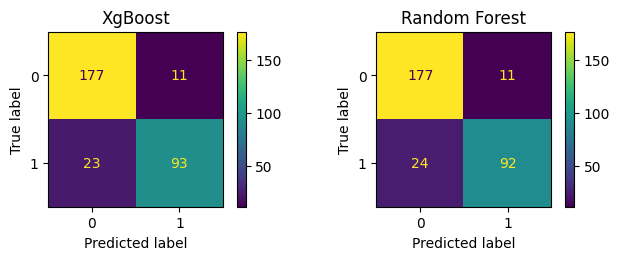

In [67]:
models = [
    ("XgBoost", ann_rad_xgb_search.best_estimator_),
    ("Random Forest", ann_rad_rf_search.best_estimator_),
]
plot_metrics(models, X_test, y_test)

### 3. CNN 

#### 3.1. CNN Shalow Features

In [ ]:
merged_df = merge_csvs(["annotations_ds.csv", "cnn_shallow.csv"])
X_train, y_train, groups_train, X_test, y_test = prepare_df(merged_df)

In [ ]:
# Tune models
cnn_shallow_xgb_search = tune_model(XGBClassifier(eval_metric="mlogloss"), xgb_param_distributions, X_train, y_train, groups_train, "XGBoost")
cnn_shallow_xgb = get_scores(cnn_shallow_xgb_search.cv_results_, cnn_shallow_xgb_search.best_index_)

cnn_shallow_rf_search = tune_model(RandomForestClassifier(random_state=42), rf_param_distributions, X_train, y_train, groups_train, "Random Forest")
cnn_shallow_rf = get_scores(cnn_shallow_rf_search.cv_results_, cnn_shallow_rf_search.best_index_)

XGBoost - Best parameters: {'feature_selection': SelectFromModel(estimator=LinearSVC(max_iter=2000, penalty='l1')), 'classifier__subsample': 0.7, 'classifier__n_estimators': 200, 'classifier__max_depth': 7, 'classifier__learning_rate': 0.1, 'classifier__gamma': 0.0, 'classifier__colsample_bytree': 0.5}
XGBoost - Best Recall score: 0.9507


Random Forest - Best parameters: {'feature_selection': 'passthrough', 'classifier__n_estimators': 250, 'classifier__min_samples_split': 2, 'classifier__min_samples_leaf': 1, 'classifier__max_features': 'sqrt', 'classifier__max_depth': 14}
Random Forest - Best Recall score: 0.9163


In [ ]:
cnn_shallow_xgb.to_csv(RESULTS/"cnn_shallow_xgb.csv")
cnn_shallow_rf.to_csv(RESULTS/"cnn_shallow_rf.csv")

In this graph, PCA0 stands out as the most important feature, with an importance score nearing 0.1, while the remaining top features fall below 0.05.
However, the associated variance is quite high sugesting the values are widely dispersed.
The bottom 5 features include aspects of the internal structure —consistent with previous experiments— and other PCA-derived features.

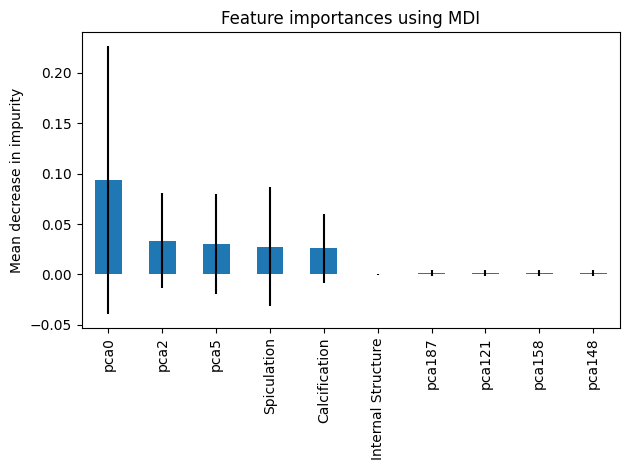

In [ ]:
feature_names = X_train.columns
_ = plot_feature_importance(cnn_shallow_rf_search.best_estimator_, feature_names)

1. **Precision**:
   - Both models have high precision, with XGBoost performing much better than Random Forest

2. **F1 Score**:
   - Both models have high F1 Score with Random Forest having a slight edge.

3. **F2 Score**:
   - Here, Random Forest outperforms XGBoost again, which may indicate that Random Forest is somewhat better at minimizing false negatives.

4. **Balanced Accuracy**:
   - Both models have high balanced accuracy, with Random Forest again slightly outperforming XGBoost.

5. **AUC (Area Under the ROC Curve)**:
   - The AUC values for both models are high, showing a robust ability to distinguish between malignant and benign nodules

#### Summary and Insights:

- **Robustness**: Both models demonstrate good precision, F1 score, balanced accuracy, and AUC. 
- In selecting a model, the choice may depend on whether recall (for sensitivity) or precision (to avoid false positives) is prioritized.


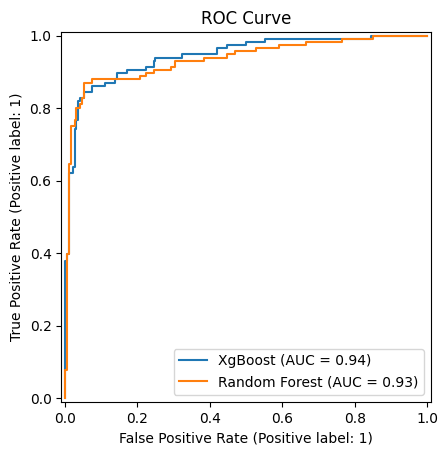

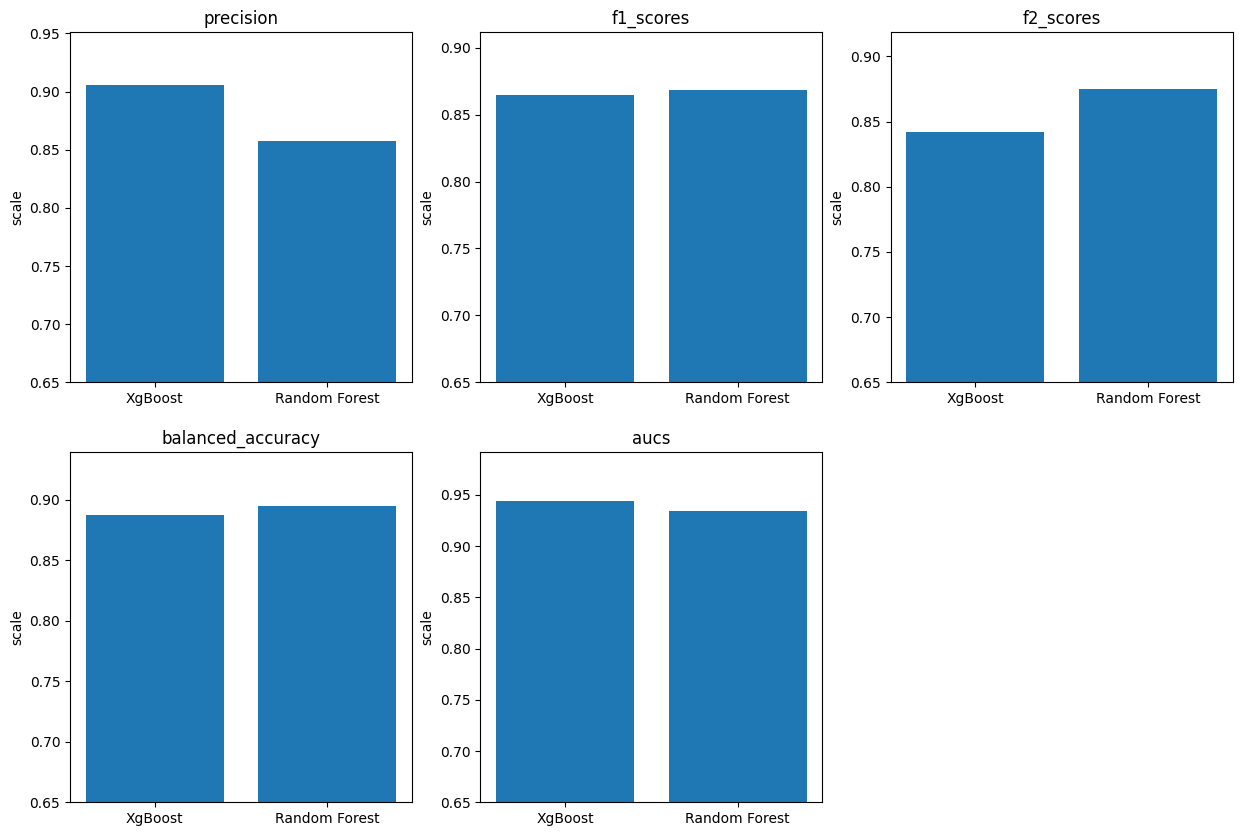

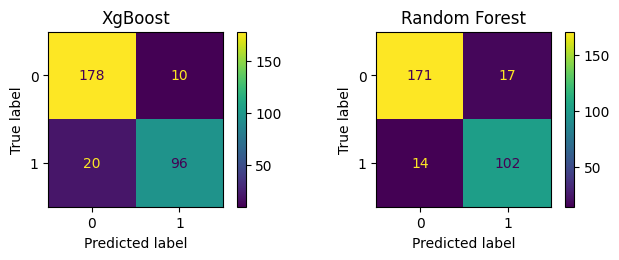

In [ ]:
models = [
    ("XgBoost", cnn_shallow_xgb_search.best_estimator_),
    ("Random Forest", cnn_shallow_rf_search.best_estimator_),
]
plot_metrics(models, X_test, y_test)

#### 3.2. CNN Deep Features

In [ ]:
merged_df = merge_csvs(["annotations_ds.csv", "cnn_deep.csv"])
X_train, y_train, groups_train, X_test, y_test = prepare_df(merged_df)

In [ ]:
# Tune models
cnn_deep_xgb_search = tune_model(XGBClassifier(eval_metric="mlogloss"), xgb_param_distributions, X_train, y_train, groups_train, "XGBoost", pca_components=-1)
cnn_deep_xgb = get_scores(cnn_deep_xgb_search.cv_results_, cnn_deep_xgb_search.best_index_)

cnn_deep_rf_search = tune_model(RandomForestClassifier(random_state=42), rf_param_distributions, X_train, y_train, groups_train, "Random Forest", pca_components=-1)
cnn_deep_rf = get_scores(cnn_deep_rf_search.cv_results_, cnn_deep_rf_search.best_index_)

XGBoost - Best parameters: {'feature_selection': 'passthrough', 'classifier__subsample': 0.7, 'classifier__n_estimators': 150, 'classifier__max_depth': 13, 'classifier__learning_rate': 0.2, 'classifier__gamma': 0.0, 'classifier__colsample_bytree': 0.7}
XGBoost - Best Recall score: 0.9227


Random Forest - Best parameters: {'feature_selection': 'passthrough', 'classifier__n_estimators': 250, 'classifier__min_samples_split': 2, 'classifier__min_samples_leaf': 1, 'classifier__max_features': 'sqrt', 'classifier__max_depth': 14}
Random Forest - Best Recall score: 0.9111


In [ ]:
cnn_deep_xgb.to_csv(RESULTS/"cnn_deep_xgb.csv")
cnn_deep_rf.to_csv(RESULTS/"cnn_deep_rf.csv")

In this case, the top features show importance scores ranging from nearly 0.1 to 0.05

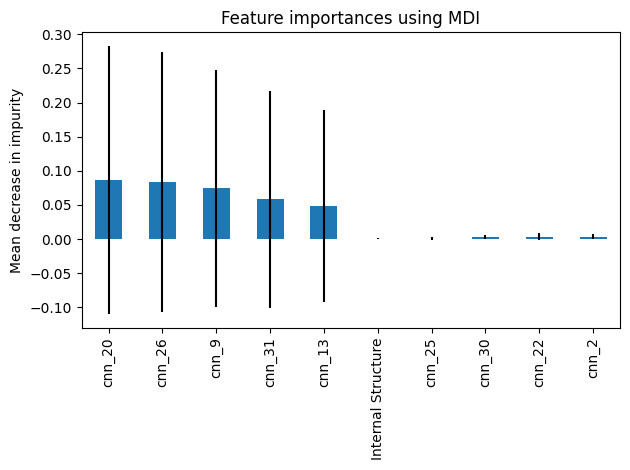

In [ ]:
feature_names = X_train.columns
_ = plot_feature_importance(cnn_deep_rf_search.best_estimator_, feature_names)

- **XGBoost** consistently shows better performance across all metrics compared to Random Forest, indicating it may be the slightly better model.
- **Robustness**: Both models demonstrate high precision, F1 score, balanced accuracy, and AUC.

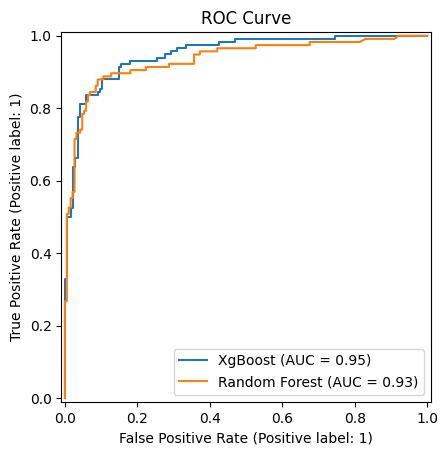

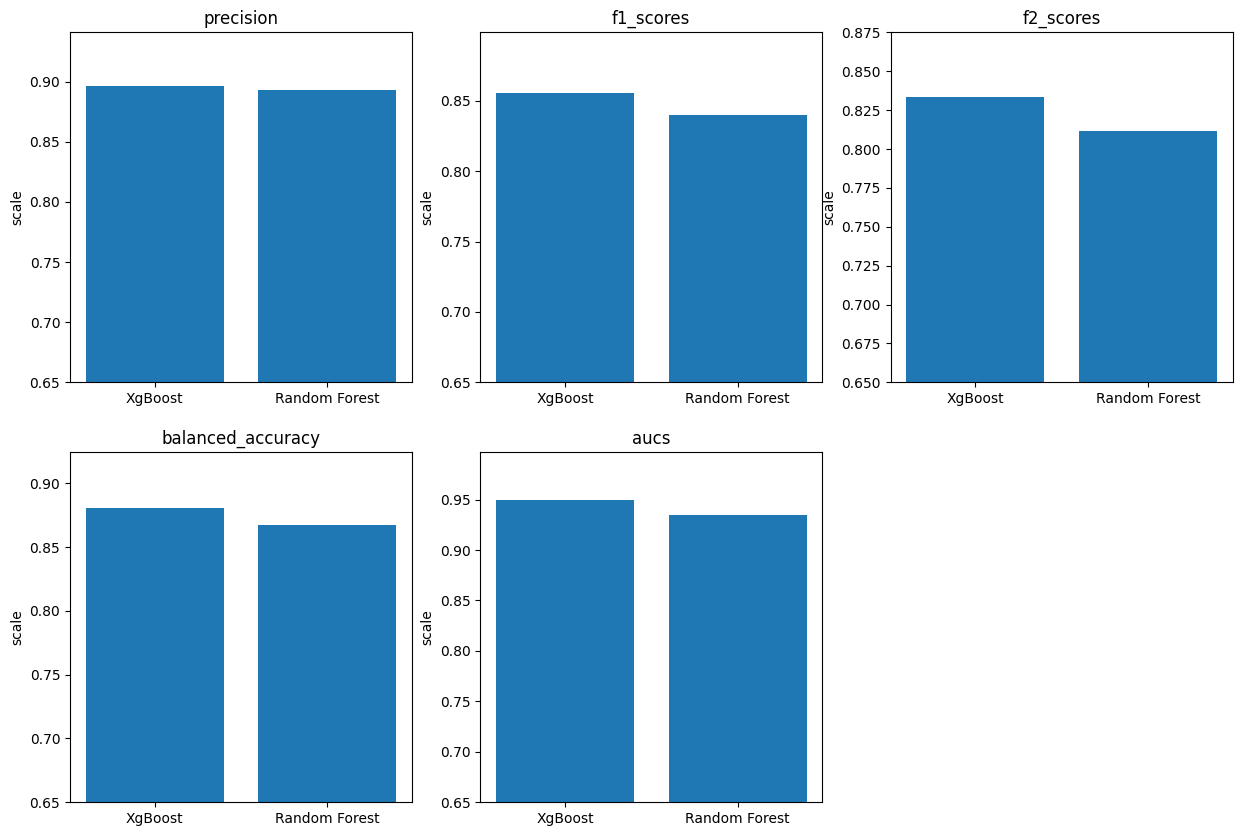

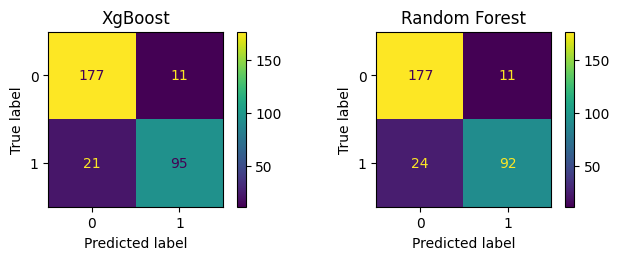

In [ ]:
models = [
    ("XgBoost", cnn_deep_xgb_search.best_estimator_),
    ("Random Forest", cnn_deep_rf_search.best_estimator_),
]
plot_metrics(models, X_test, y_test)

#### 3.3. CNN PCA pre-trained 

In [ ]:
merged_df = merge_csvs(["annotations_ds.csv", "cnn_pretrained.csv"])
X_train, y_train, groups_train, X_test, y_test = prepare_df(merged_df)

In [ ]:
# Tune models
cnn_pretrained_xgb_search = tune_model(XGBClassifier(eval_metric="mlogloss"), xgb_param_distributions, X_train, y_train, groups_train, "XGBoost")
cnn_pretrained_xgb = get_scores(cnn_pretrained_xgb_search.cv_results_, cnn_pretrained_xgb_search.best_index_)

cnn_pretrained_rf_search = tune_model(RandomForestClassifier(random_state=42), rf_param_distributions, X_train, y_train, groups_train, "Random Forest")
cnn_pretrained_rf = get_scores(cnn_pretrained_rf_search.cv_results_, cnn_pretrained_rf_search.best_index_)

XGBoost - Best parameters: {'feature_selection': SelectFromModel(estimator=LinearSVC(max_iter=2000, penalty='l1')), 'classifier__subsample': 0.7, 'classifier__n_estimators': 200, 'classifier__max_depth': 7, 'classifier__learning_rate': 0.1, 'classifier__gamma': 0.0, 'classifier__colsample_bytree': 0.5}
XGBoost - Best Recall score: 0.9394


Random Forest - Best parameters: {'feature_selection': 'passthrough', 'classifier__n_estimators': 100, 'classifier__min_samples_split': 2, 'classifier__min_samples_leaf': 1, 'classifier__max_features': 'sqrt', 'classifier__max_depth': 14}
Random Forest - Best Recall score: 0.9023


In [ ]:
cnn_pretrained_xgb.to_csv(RESULTS/"cnn_pretrained_xgb.csv")
cnn_pretrained_rf.to_csv(RESULTS/"cnn_pretrained_rf.csv")

This time pca0 is over 0.1 and features from annotations are more important.

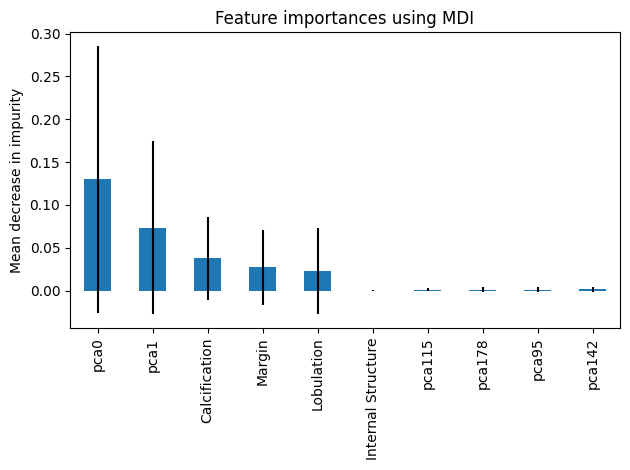

In [ ]:
feature_names = X_train.columns
_ = plot_feature_importance(cnn_pretrained_rf_search.best_estimator_, feature_names)

1. **Precision**:
   - Both models have high precision, with XGBoost performing slightly better than Random Forest.

2. **F1 Score**:
   - Both models perform similarly, with Random Forest having a barely edge suggesting robustness in handling the classification task.

3. **F2 Score**:
   - Here, Random Forest slightly outperforms XGBoost, which may indicate that XGBoost is somewhat better at minimizing false negatives.

4. **Balanced Accuracy**:
   - Both models have high balanced accuracy, with Random Forest again barely outperforming XGBoost.

5. **AUC (Area Under the ROC Curve)**:
   - The AUC values for both models are high, showing excellent ability to distinguish between malignant and benign nodules.

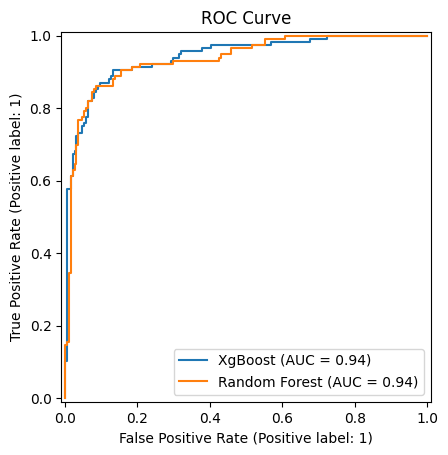

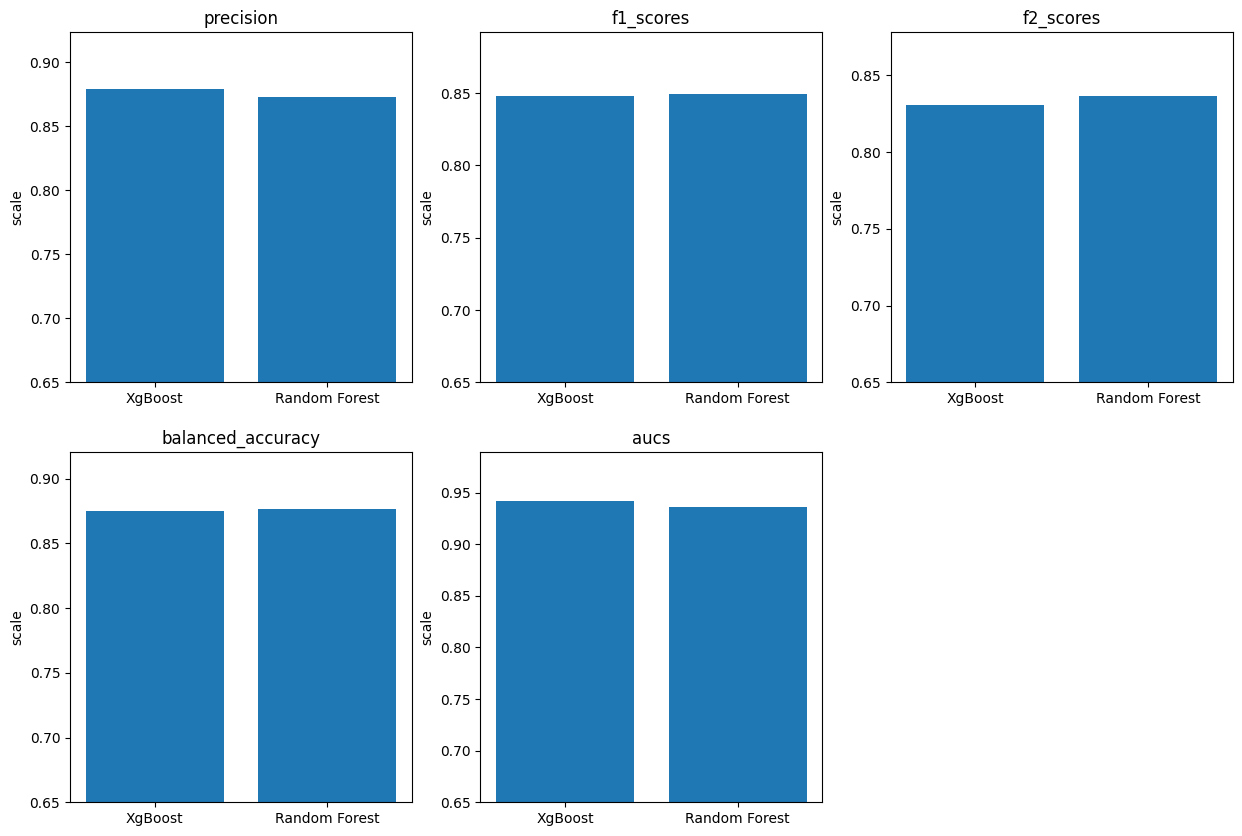

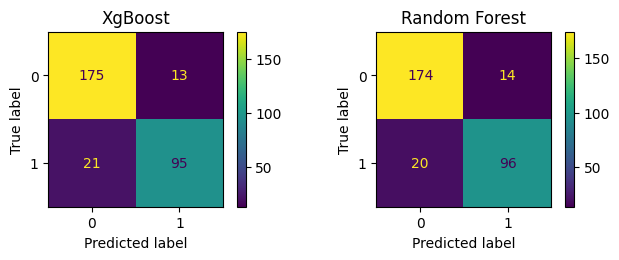

In [ ]:
models = [
    ("XgBoost", cnn_pretrained_xgb_search.best_estimator_),
    ("Random Forest", cnn_pretrained_rf_search.best_estimator_),
]
plot_metrics(models, X_test, y_test)

### 4. Annotations + Radiomics + NN

In [68]:
merged_df = merge_csvs(["annotations_ds.csv", "radiomics.csv", "cnn_shallow.csv"])
X_train, y_train, groups_train, X_test, y_test = prepare_df(merged_df)

In [69]:
# Tune models
ann_rad_nn_xgb_search = tune_model(XGBClassifier(eval_metric="mlogloss"), xgb_param_distributions, X_train, y_train, groups_train, "XGBoost")
ann_rad_nn_xgb = get_scores(ann_rad_nn_xgb_search.cv_results_, ann_rad_nn_xgb_search.best_index_)

ann_rad_nn_rf_search = tune_model(RandomForestClassifier(random_state=42), rf_param_distributions, X_train, y_train, groups_train, "Random Forest")
ann_rad_nn_rf = get_scores(ann_rad_nn_rf_search.cv_results_, ann_rad_nn_rf_search.best_index_)

XGBoost - Best parameters: {'feature_selection': SelectFromModel(estimator=LinearSVC(max_iter=2000, penalty='l1')), 'classifier__subsample': 0.7, 'classifier__n_estimators': 250, 'classifier__max_depth': 12, 'classifier__learning_rate': 0.1, 'classifier__gamma': 0.0, 'classifier__colsample_bytree': 0.5}
XGBoost - Best Recall score: 0.9487


Random Forest - Best parameters: {'feature_selection': 'passthrough', 'classifier__n_estimators': 250, 'classifier__min_samples_split': 2, 'classifier__min_samples_leaf': 1, 'classifier__max_features': 'sqrt', 'classifier__max_depth': 14}
Random Forest - Best Recall score: 0.9201


In [70]:
ann_rad_nn_xgb.to_csv(RESULTS/"ann_rad_nn_xgb.csv")
ann_rad_nn_rf.to_csv(RESULTS/"ann_rad_nn_rf.csv")

Features from radiomics seem to be the most important ones.

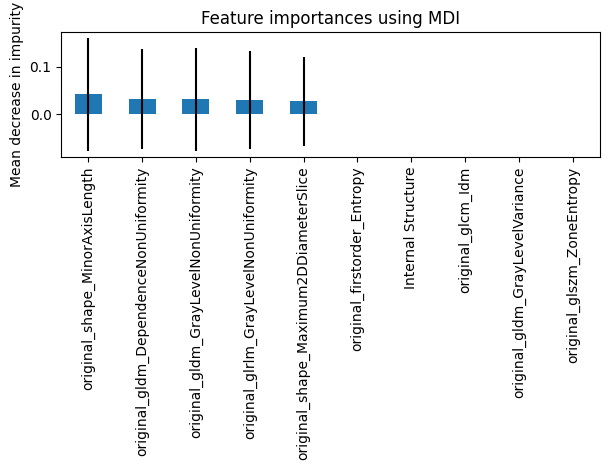

In [71]:
feature_names = X_train.columns
_ = plot_feature_importance(ann_rad_nn_rf_search.best_estimator_, feature_names)

Consistent with what we saw previously, **XGBoost** performs better in terms of precision and AUC but Random Forest has a slight edge on the other metrics.

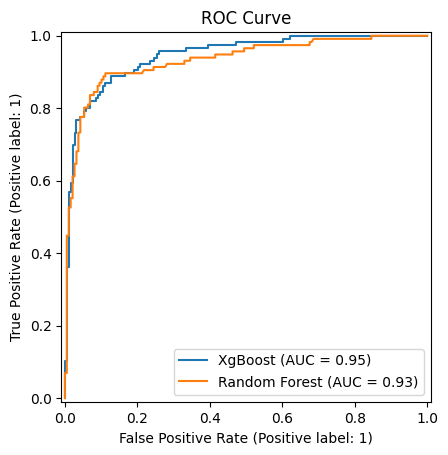

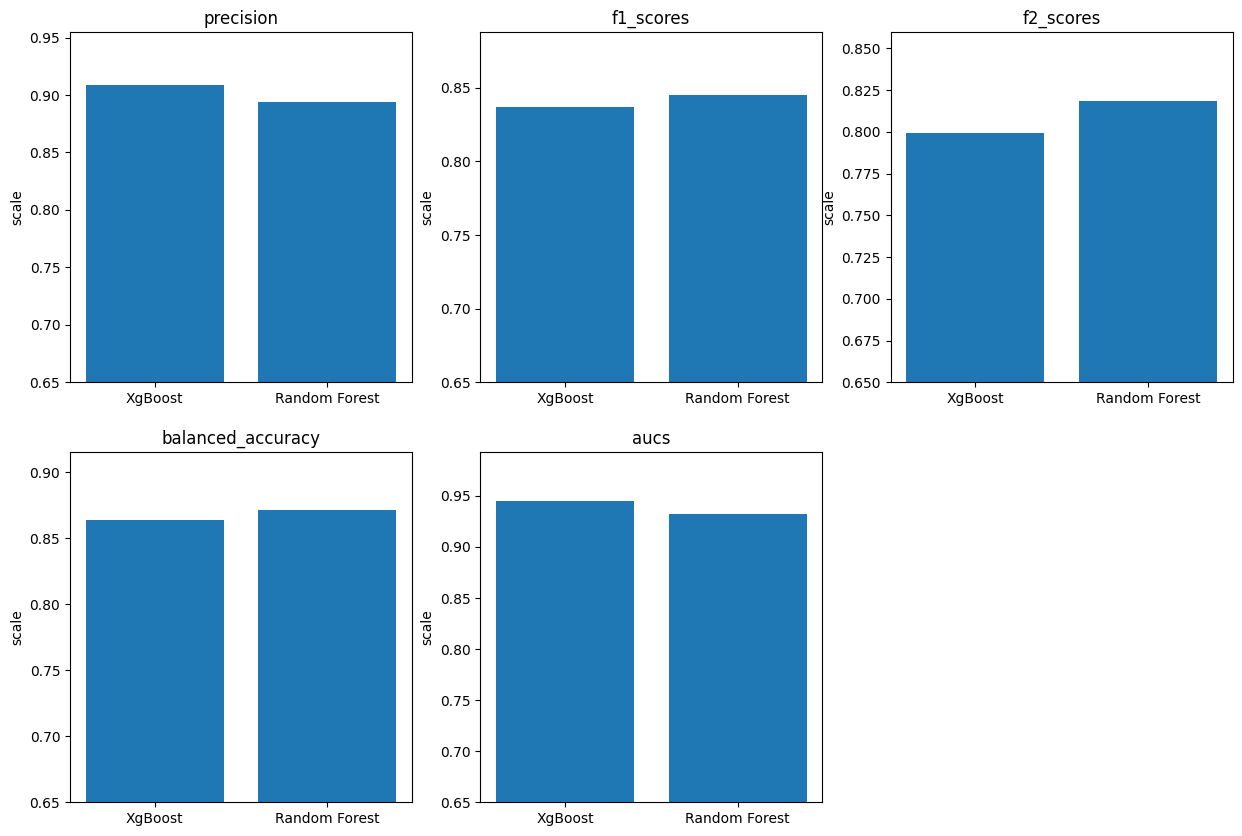

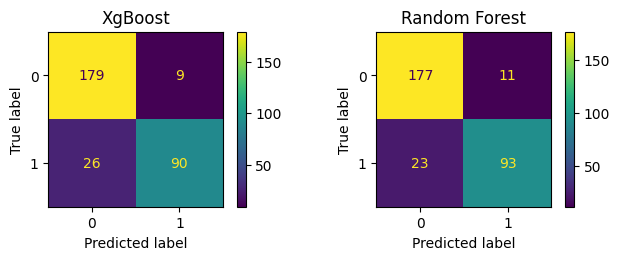

In [72]:
models = [
    ("XgBoost", ann_rad_nn_xgb_search.best_estimator_),
    ("Random Forest", ann_rad_nn_rf_search.best_estimator_),
]
plot_metrics(models, X_test, y_test)

### 5. Annotations + Sound


In [17]:
merged_df = merge_csvs(["annotations_ds.csv", "sound.csv"])
X_train, y_train, groups_train, X_test, y_test = prepare_df(merged_df)

In [18]:
# Tune models
ann_sound_xgb_search = tune_model(XGBClassifier(eval_metric="mlogloss"), xgb_param_distributions, X_train, y_train, groups_train, "XGBoost")
ann_sound_xgb = get_scores(ann_sound_xgb_search.cv_results_, ann_sound_xgb_search.best_index_)

ann_sound_rf_search = tune_model(RandomForestClassifier(random_state=42), rf_param_distributions, X_train, y_train, groups_train, "Random Forest")
ann_sound_rf = get_scores(ann_sound_rf_search.cv_results_, ann_sound_rf_search.best_index_)

XGBoost - Best parameters: {'feature_selection': SelectFromModel(estimator=LinearSVC(max_iter=2000, penalty='l1')), 'classifier__subsample': 0.7, 'classifier__n_estimators': 200, 'classifier__max_depth': 7, 'classifier__learning_rate': 0.1, 'classifier__gamma': 0.0, 'classifier__colsample_bytree': 0.5}
XGBoost - Best Recall score: 0.9387
Random Forest - Best parameters: {'feature_selection': 'passthrough', 'classifier__n_estimators': 100, 'classifier__min_samples_split': 2, 'classifier__min_samples_leaf': 1, 'classifier__max_features': 'sqrt', 'classifier__max_depth': 14}
Random Forest - Best Recall score: 0.9119


In [22]:
ann_sound_xgb.to_csv(RESULTS/"ann_sound_xgb.csv")
ann_sound_rf.to_csv(RESULTS/"ann_sound_rf.csv")

This graph suggests that `tempo`, `zero crossing rate (ZCR)` and `bandwidth_mean` are relevant in distinguishing malignant nodules.

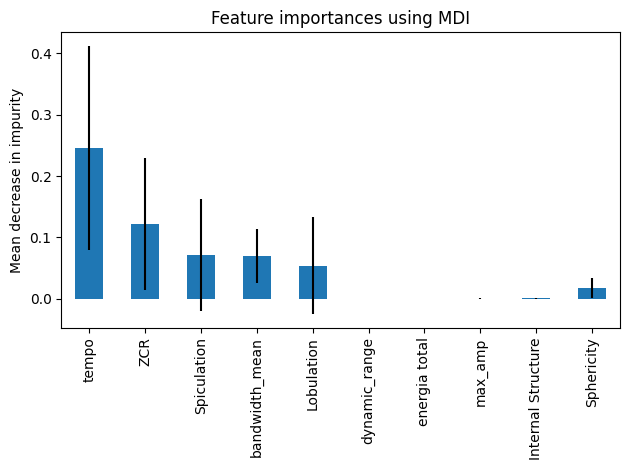

In [23]:
feature_names = X_train.columns
_ = plot_feature_importance(ann_sound_rf_search.best_estimator_, feature_names)

1. **Precision**:
   - Both models have high precision, with XGBoost performing slightly better than Random Forest.

2. **F1 Score**:
   - Both models perform similarly, with XGBoost having a slight edge siggesting robustness in handling the classification task.

3. **F2 Score**:
   - Here, XGBoost slightly outperforms Random Forest, which may indicate that XGBoost is somewhat better at minimizing false negatives.

4. **Balanced Accuracy**:
   - Both models have high balanced accuracy, with XGBoost again slightly outperforming Random Forest, making them reliable for diverse patient populations with varying nodule types.

5. **AUC (Area Under the ROC Curve)**:
   - The AUC values for both models are high, showing excellent ability to distinguish between malignant and benign nodules.

#### Summary and Insights:

- **XGBoost** consistently shows a slight edge across all metrics compared to Random Forest, indicating it may be the better model for this task.
- **Robustness**: Both models demonstrate high precision, F1 score, balanced accuracy, and AUC, indicating they are robust in their ability to accurately classify lung nodules.
- **Sensitivity to Malignancy**: The higher F2 score for XGBoost suggests it may be more reliable in identifying malignant nodules, which is crucial in a task where missing a malignancy can have severe implications.

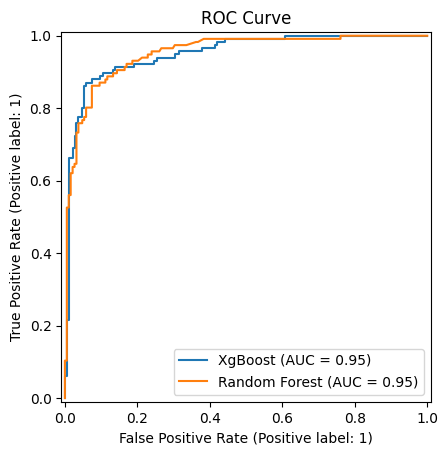

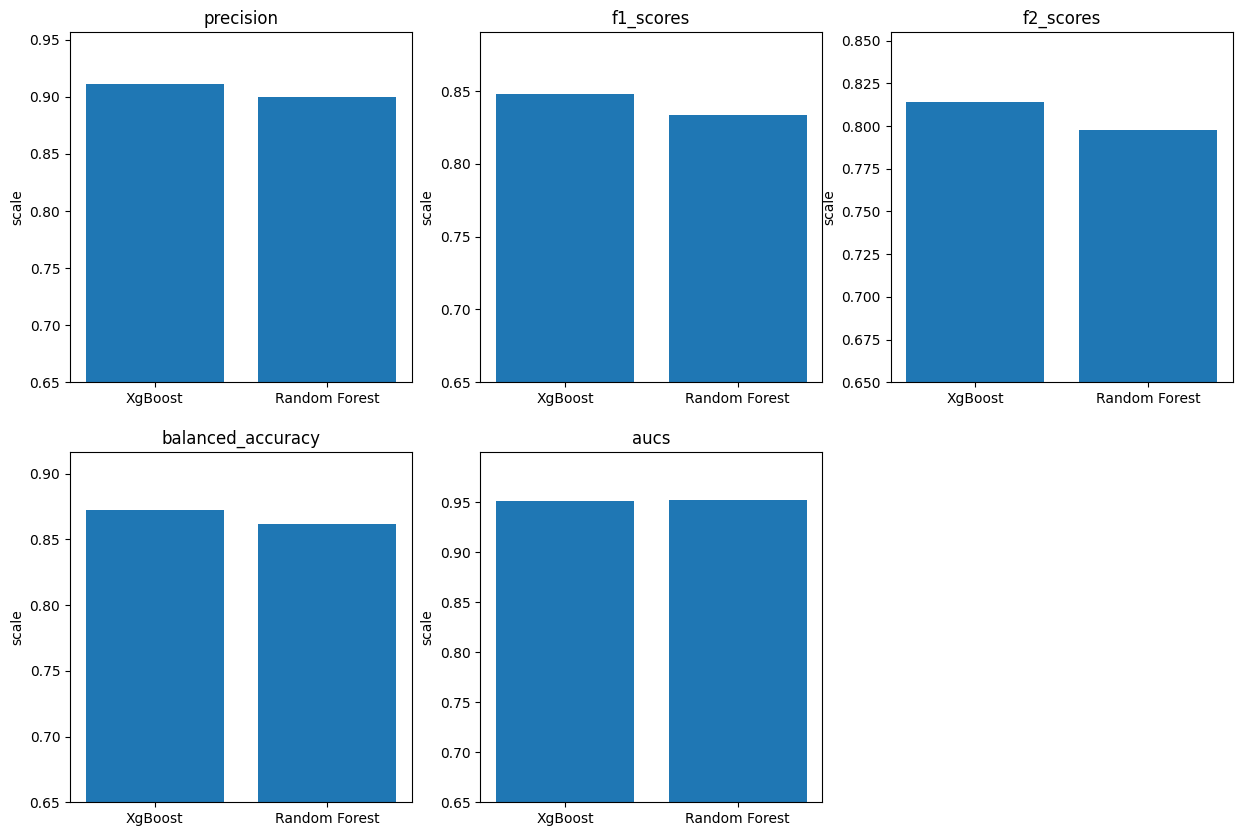

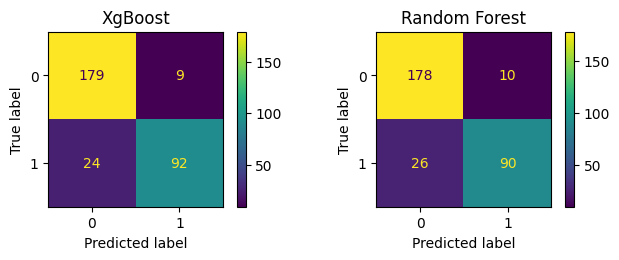

In [24]:
models = [
    ("XgBoost", ann_sound_xgb_search.best_estimator_),
    ("Random Forest", ann_sound_rf_search.best_estimator_),
]
plot_metrics(models, X_test, y_test)

### 6. Annotations + Radiomics + Sound

In [25]:
merged_df = merge_csvs(["annotations_ds.csv", "radiomics.csv","sound.csv"])
X_train, y_train, groups_train, X_test, y_test = prepare_df(merged_df)

In [27]:
# Tune models
ann_sound_radiomics_xgb_search = tune_model(XGBClassifier(eval_metric="mlogloss"), xgb_param_distributions, X_train, y_train, groups_train, "XGBoost")
ann_sound_radiomics_xgb = get_scores(ann_sound_radiomics_xgb_search.cv_results_, ann_sound_radiomics_xgb_search.best_index_)

ann_sound_radiomics_rf_search = tune_model(RandomForestClassifier(random_state=42), rf_param_distributions, X_train, y_train, groups_train, "Random Forest")
ann_sound_radiomics_rf = get_scores(ann_sound_radiomics_rf_search.cv_results_, ann_sound_radiomics_rf_search.best_index_)

XGBoost - Best parameters: {'feature_selection': 'passthrough', 'classifier__subsample': 0.7, 'classifier__n_estimators': 150, 'classifier__max_depth': 13, 'classifier__learning_rate': 0.2, 'classifier__gamma': 0.0, 'classifier__colsample_bytree': 0.7}
XGBoost - Best Recall score: 0.9361


Random Forest - Best parameters: {'feature_selection': 'passthrough', 'classifier__n_estimators': 50, 'classifier__min_samples_split': 2, 'classifier__min_samples_leaf': 2, 'classifier__max_features': 'log2', 'classifier__max_depth': 14}
Random Forest - Best Recall score: 0.9105


In [28]:
ann_sound_radiomics_xgb.to_csv(RESULTS/"ann_sound_radiomics_xgb.csv")
ann_sound_radiomics_rf.to_csv(RESULTS/"ann_sound_radiomics_rf.csv")

This time radiomics has claimed the top spots and features from sound are not as relevant.

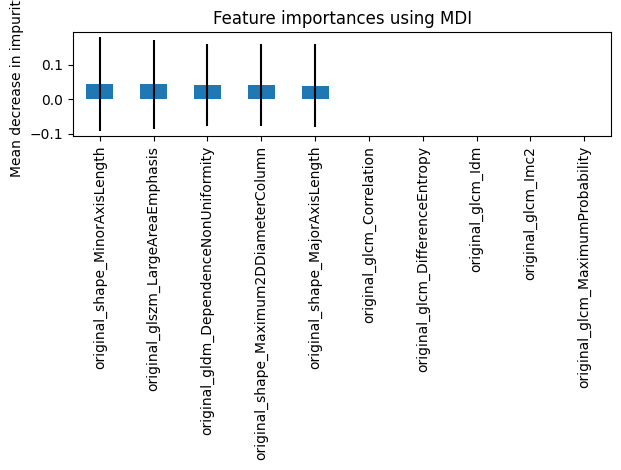

In [29]:
feature_names = X_train.columns
_ = plot_feature_importance(ann_sound_radiomics_rf_search.best_estimator_, feature_names)

All metrics for both models are very high but **Random Forest** has a slight edge on F2 Score.

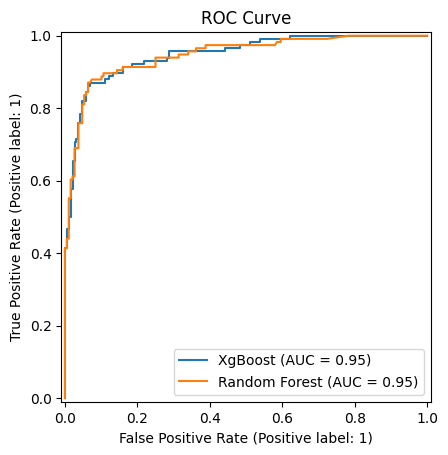

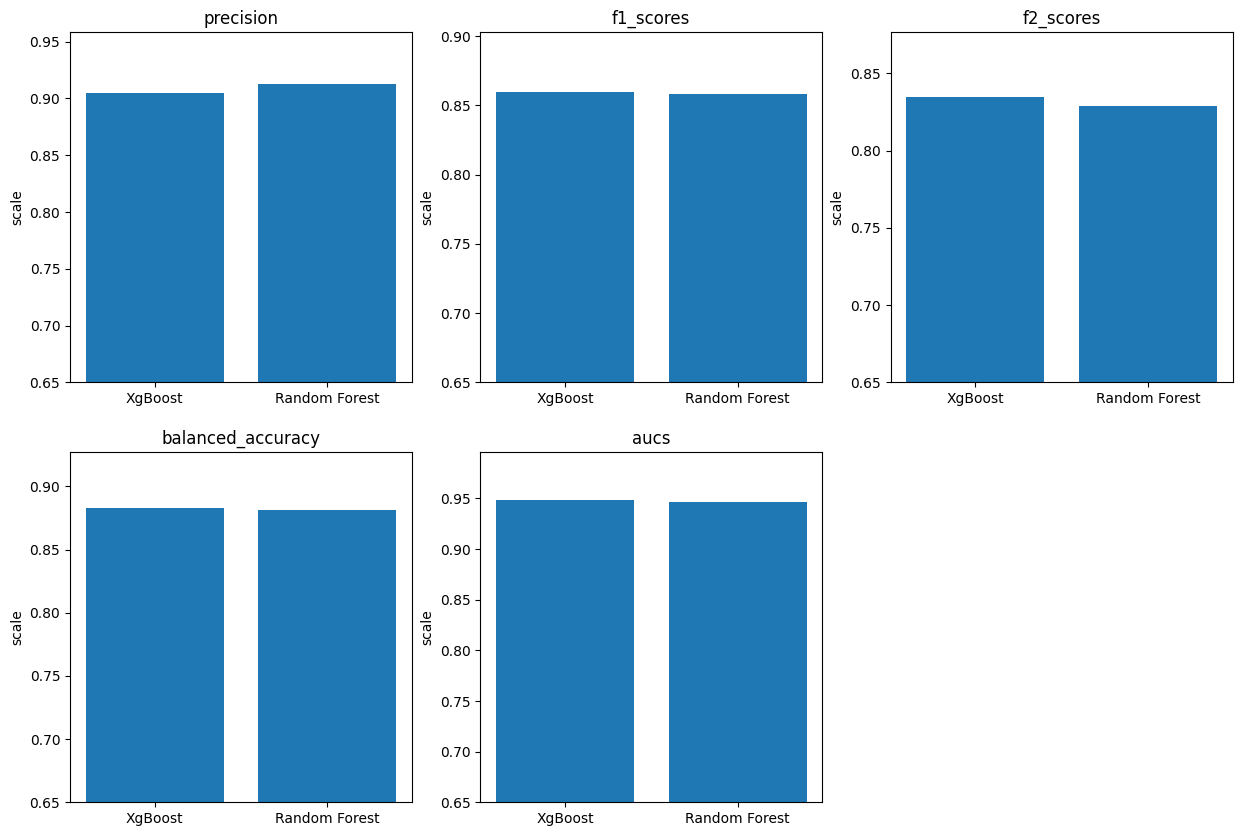

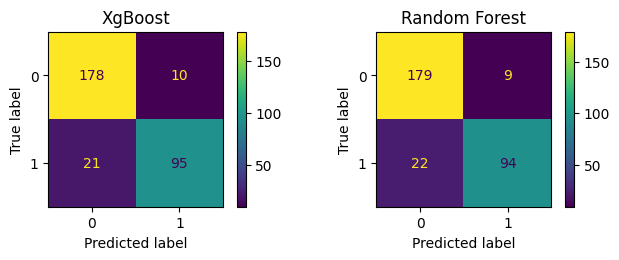

In [30]:
models = [
    ("XgBoost", ann_sound_radiomics_xgb_search.best_estimator_),
    ("Random Forest", ann_sound_radiomics_rf_search.best_estimator_),
]
plot_metrics(models, X_test, y_test)

### 7. Annotations + NN + Sound

In [32]:
merged_df = merge_csvs(["annotations_ds.csv", "cnn_shallow.csv","sound.csv"])
X_train, y_train, groups_train, X_test, y_test = prepare_df(merged_df)

In [33]:
# Tune models
ann_sound_nn_xgb_search = tune_model(XGBClassifier(eval_metric="mlogloss"), xgb_param_distributions, X_train, y_train, groups_train, "XGBoost")
ann_sound_nn_xgb = get_scores(ann_sound_nn_xgb_search.cv_results_, ann_sound_nn_xgb_search.best_index_)
ann_sound_nn_rf_search = tune_model(RandomForestClassifier(random_state=42), rf_param_distributions, X_train, y_train, groups_train, "Random Forest")
ann_sound_nn_rf = get_scores(ann_sound_nn_rf_search.cv_results_, ann_sound_nn_rf_search.best_index_)

XGBoost - Best parameters: {'feature_selection': 'passthrough', 'classifier__subsample': 0.7, 'classifier__n_estimators': 150, 'classifier__max_depth': 13, 'classifier__learning_rate': 0.2, 'classifier__gamma': 0.0, 'classifier__colsample_bytree': 0.7}
XGBoost - Best Recall score: 0.9545


Random Forest - Best parameters: {'feature_selection': 'passthrough', 'classifier__n_estimators': 250, 'classifier__min_samples_split': 2, 'classifier__min_samples_leaf': 1, 'classifier__max_features': 'sqrt', 'classifier__max_depth': 14}
Random Forest - Best Recall score: 0.9128


In [34]:
ann_sound_nn_xgb.to_csv(RESULTS/"ann_sound_nn_xgb.csv")
ann_sound_nn_rf.to_csv(RESULTS/"ann_sound_nn_rf.csv")

Here, all datasets have features in the top places, with `tempo` being the most important one.

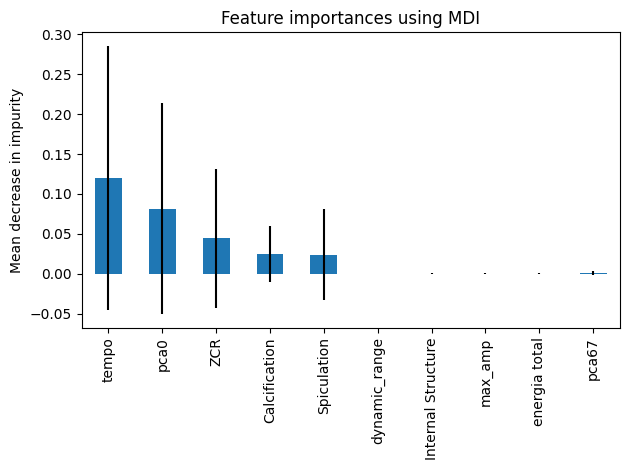

In [35]:
feature_names = X_train.columns
_ = plot_feature_importance(ann_sound_nn_rf_search.best_estimator_, feature_names)

- Here we can see that **Random Forest** is much better at minimizing false negatives, but at the cost of higher false positive rates.
- XGBoost has better precision and AUC but Random Forest is better in other metrics.

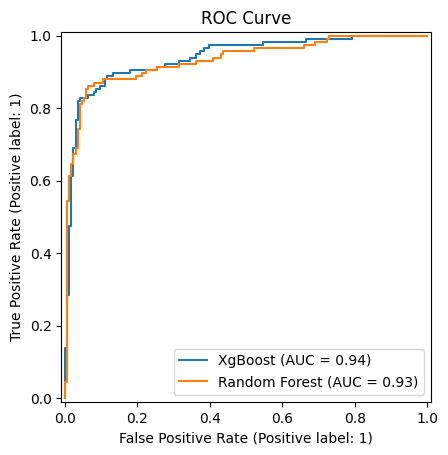

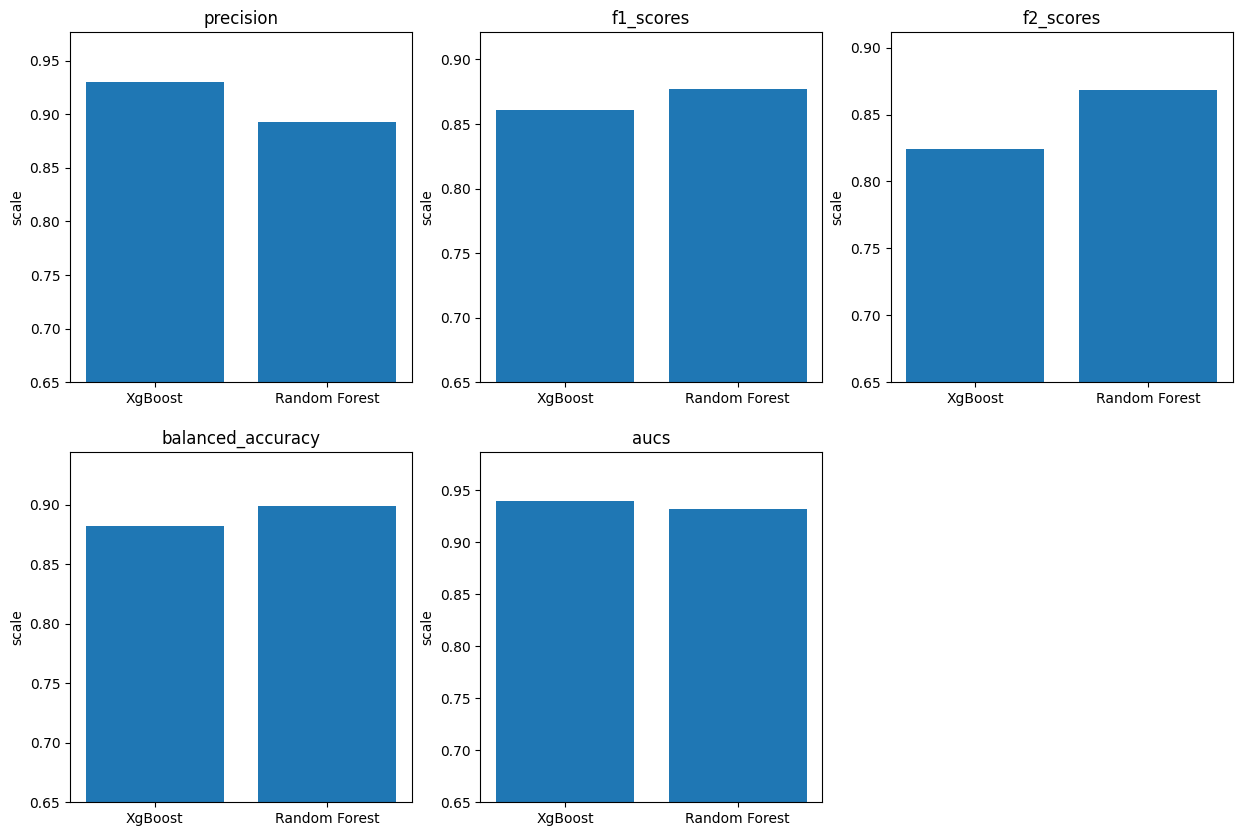

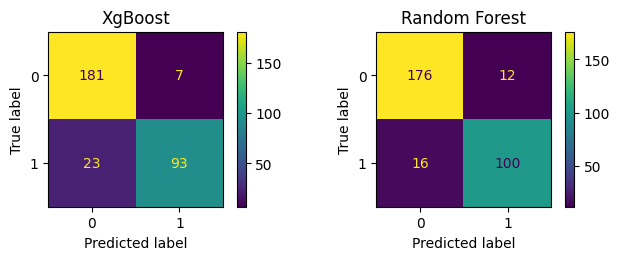

In [36]:
models = [
    ("XgBoost", ann_sound_nn_xgb_search.best_estimator_),
    ("Random Forest", ann_sound_nn_rf_search.best_estimator_),
]
plot_metrics(models, X_test, y_test)

### 8. Annotations + Radiomics + NN + Sound

In [39]:
merged_df = merge_csvs(["annotations_ds.csv", "radiomics.csv","cnn_shallow.csv","sound.csv"])
X_train, y_train, groups_train, X_test, y_test = prepare_df(merged_df)

In [40]:
# Tune models
ann_radiomics_nn_sound_xgb_search = tune_model(XGBClassifier(eval_metric="mlogloss"), xgb_param_distributions, X_train, y_train, groups_train, "XGBoost")
ann_radiomics_nn_sound_xgb = get_scores(ann_radiomics_nn_sound_xgb_search.cv_results_, ann_radiomics_nn_sound_xgb_search.best_index_)

ann_radiomics_nn_sound_rf_search = tune_model(RandomForestClassifier(random_state=42), rf_param_distributions, X_train, y_train, groups_train, "Random Forest")
ann_radiomics_nn_sound_rf = get_scores(ann_radiomics_nn_sound_rf_search.cv_results_, ann_radiomics_nn_sound_rf_search.best_index_)

XGBoost - Best parameters: {'feature_selection': SelectFromModel(estimator=LinearSVC(max_iter=2000, penalty='l1')), 'classifier__subsample': 0.5, 'classifier__n_estimators': 150, 'classifier__max_depth': 14, 'classifier__learning_rate': 0.2, 'classifier__gamma': 0.5, 'classifier__colsample_bytree': 0.7}
XGBoost - Best Recall score: 0.9479


Random Forest - Best parameters: {'feature_selection': 'passthrough', 'classifier__n_estimators': 250, 'classifier__min_samples_split': 2, 'classifier__min_samples_leaf': 1, 'classifier__max_features': 'sqrt', 'classifier__max_depth': 14}
Random Forest - Best Recall score: 0.9169


In [41]:
ann_radiomics_nn_sound_xgb.to_csv(RESULTS/"ann_radiomics_nn_sound_xgb.csv")
ann_radiomics_nn_sound_rf.to_csv(RESULTS/"ann_radiomics_nn_sound_rf.csv")

As usual radiomics claims the top spots for feature importance.

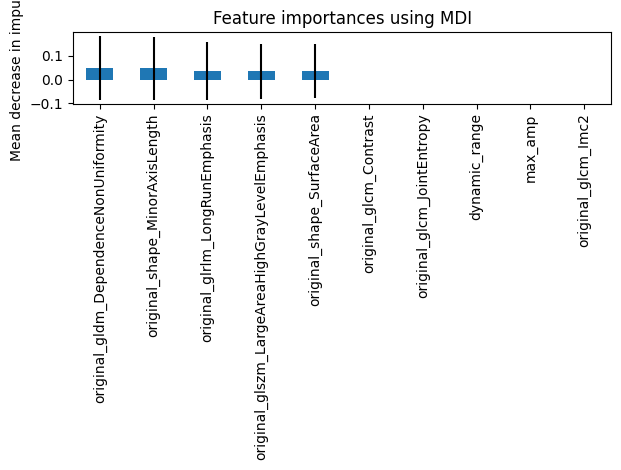

In [42]:
feature_names = X_train.columns
_ = plot_feature_importance(ann_radiomics_nn_sound_rf_search.best_estimator_, feature_names)

- **Random Forest** consistently shows a slight edge across all metrics compared to XGBoost except in AUC where XGBoost has a slight edge.

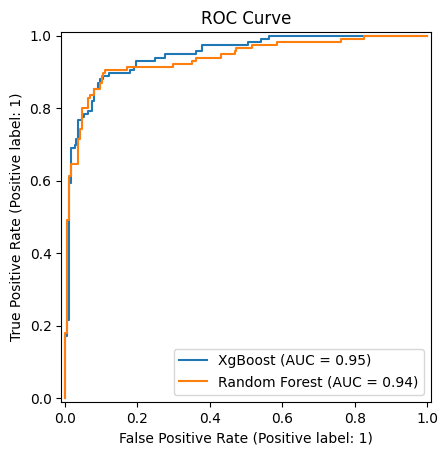

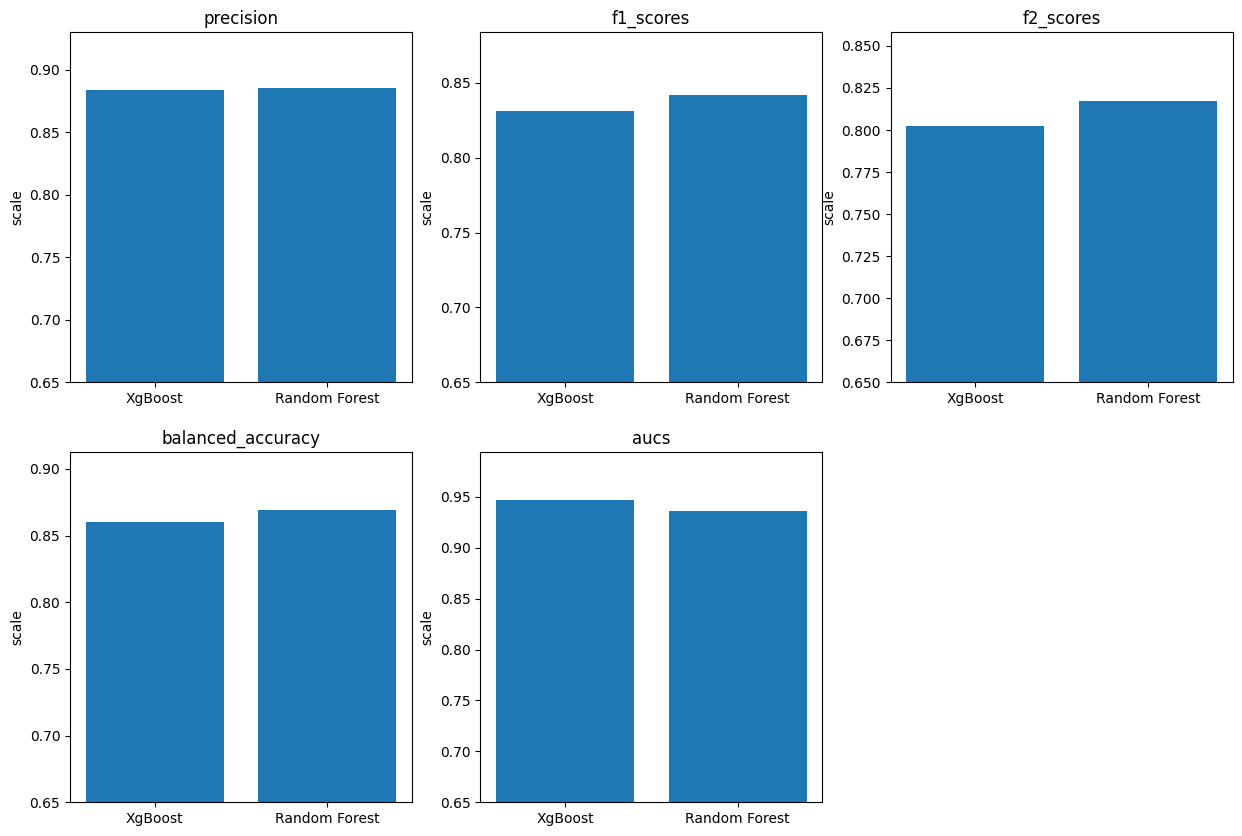

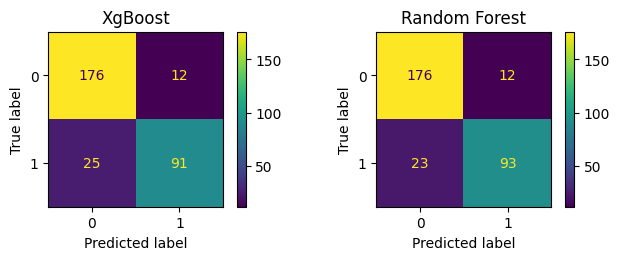

In [43]:
models = [
    ("XgBoost", ann_radiomics_nn_sound_xgb_search.best_estimator_),
    ("Random Forest", ann_radiomics_nn_sound_rf_search.best_estimator_),
]
plot_metrics(models, X_test, y_test)

---

## Hypothesis test

In [44]:
import matplotlib.pyplot as plt
import scipy.stats as stats
import scikit_posthocs as sp
import pandas as pd

In [45]:
ann_xgb = pd.read_csv(RESULTS/"ann_xgb.csv", index_col=0)
ann_rf = pd.read_csv(RESULTS/"ann_rf.csv", index_col=0)
ann_rad_xgb = pd.read_csv(RESULTS/"ann_rad_xgb.csv", index_col=0)
ann_rad_rf = pd.read_csv(RESULTS/"ann_rad_rf.csv", index_col=0)
cnn_shallow_xgb = pd.read_csv(RESULTS/"cnn_shallow_xgb.csv", index_col=0)
cnn_shallow_rf = pd.read_csv(RESULTS/"cnn_shallow_rf.csv", index_col=0)
ann_rad_nn_xgb = pd.read_csv(RESULTS/"ann_rad_nn_xgb.csv", index_col=0)
ann_rad_nn_rf = pd.read_csv(RESULTS/"ann_rad_nn_rf.csv", index_col=0)
ann_sound_xgb = pd.read_csv(RESULTS/"ann_sound_xgb.csv", index_col=0)
ann_sound_rf = pd.read_csv(RESULTS/"ann_sound_rf.csv", index_col=0)
ann_sound_radiomics_xgb = pd.read_csv(RESULTS/"ann_sound_radiomics_xgb.csv", index_col=0)
ann_sound_radiomics_rf = pd.read_csv(RESULTS/"ann_sound_radiomics_rf.csv", index_col=0)
ann_sound_nn_xgb = pd.read_csv(RESULTS/"ann_sound_nn_xgb.csv", index_col=0)
ann_sound_nn_rf = pd.read_csv(RESULTS/"ann_sound_nn_rf.csv", index_col=0)
ann_radiomics_nn_sound_xgb = pd.read_csv(RESULTS/"ann_radiomics_nn_sound_xgb.csv", index_col=0)
ann_radiomics_nn_sound_rf = pd.read_csv(RESULTS/"ann_radiomics_nn_sound_rf.csv", index_col=0)

In [46]:
scores_df = pd.concat([
    ann_xgb.add_prefix("ann_xgb_"),
    ann_rf.add_prefix("ann_rf_"),
    ann_rad_xgb.add_prefix("ann-rad_xgb_"),
    ann_rad_rf.add_prefix("ann-rad_rf_"),
    cnn_shallow_xgb.add_prefix("cnn_xgb_"), 
    cnn_shallow_rf.add_prefix("cnn_rf_"),  
    ann_rad_nn_xgb.add_prefix("ann-rad-cnn_xgb_"),
    ann_rad_nn_rf.add_prefix("ann-rad-cnn_rf_"),
    ann_sound_xgb.add_prefix("ann-sound_xgb_"),
    ann_sound_rf.add_prefix("ann-sound_rf_"),
    ann_sound_radiomics_xgb.add_prefix("ann-sound-radiomics_xgb_"),
    ann_sound_radiomics_rf.add_prefix("ann-sound-radiomics_rf_"),
    ann_sound_nn_xgb.add_prefix("ann-sound-nn_xgb_"),
    ann_sound_nn_rf.add_prefix("ann-sound-nn_rf_"),
    ann_radiomics_nn_sound_xgb.add_prefix("ann-radiomics-nn-sound_xgb_"),
    ann_radiomics_nn_sound_rf.add_prefix("ann-radiomics-nn-sound_rf_"),
], axis=1)
scores_df.head()

,ann_xgb_recall,ann_xgb_precision,ann_xgb_f1,ann_xgb_f2,ann_xgb_balanced,ann_xgb_auc,ann_rf_recall,ann_rf_precision,ann_rf_f1,ann_rf_f2,...,ann-radiomics-nn-sound_xgb_f1,ann-radiomics-nn-sound_xgb_f2,ann-radiomics-nn-sound_xgb_balanced,ann-radiomics-nn-sound_xgb_auc,ann-radiomics-nn-sound_rf_recall,ann-radiomics-nn-sound_rf_precision,ann-radiomics-nn-sound_rf_f1,ann-radiomics-nn-sound_rf_f2,ann-radiomics-nn-sound_rf_balanced,ann-radiomics-nn-sound_rf_auc
0,0.865979,0.898396,0.881890,0.872274,0.882458,0.952182,0.876289,0.885417,0.880829,0.878099,...,0.946602,0.969185,0.949438,0.988231,0.949495,0.903846,0.926108,0.940000,0.929499,0.980655
1,0.907216,0.854369,0.880000,0.896130,0.867894,0.941119,0.896907,0.840580,0.867830,0.885046,...,0.959569,0.967391,0.959601,0.983460,0.945355,0.930108,0.937669,0.942266,0.937918,0.974022
2,0.816092,0.840237,0.827988,0.820809,0.835073,0.926949,0.839080,0.853801,0.846377,0.841984,...,0.935829,0.926907,0.933580,0.983202,0.915789,0.966667,0.940541,0.925532,0.939931,0.979420
3,0.840796,0.871134,0.855696,0.846693,0.862528,0.939895,0.845771,0.867347,0.856423,0.850000,...,0.919355,0.931373,0.923886,0.977385,0.868132,0.902857,0.885154,0.874862,0.893003,0.965201
4,0.878613,0.821622,0.849162,0.866591,0.843376,0.930132,0.884393,0.831522,0.857143,0.873288,...,0.904884,0.914761,0.892832,0.963383,0.905759,0.887179,0.896373,0.901981,0.884978,0.961185


These boxplots display performance metrics for different machine learning models used to classify lung nodule malignancy in the validation set.

From this point onwards we will refer to every model by \<datasets-used\>\_\<classifier\>\_\<metric\>.
The datasets are annotations (ann), radiomics (rad), sound (sound) and the shallow features from our trained NN (cnn).
The classifiers are XGBoost (xgb) and Random Forest (rf).
For example:
- ann-rad_xgb is XGBoost trained with the "annotations" and "radiomics" features

Here’s a breakdown of each metric and its significance:

1. **Recall**: From the plot, several models achieve high recall, with some variability in performance. Models with higher medians and smaller interquartile ranges are more consistent in recall.

2. **Precision**: Some models show a slight trade-off between precision and recall, where high precision might coincide with lower recall. 

3. **F1 and F2 Score**: Most models have a high F1 and F2 score, indicating an overall strong performance across both precision and recall.

5. **Balanced Accuracy**: The balanced accuracy scores are generally high, suggesting that most models perform well across both malignant and benign nodule classifications.

6. **AUC (Area Under the Curve)**: Most models exhibit high AUC values, with some nearing 0.97–0.99, which is excellent in terms of classification capability.

### Summary of Model Performance
- Models with consistently high recall, F2 score, and AUC (e.g., models near the top in these boxplots with tight distributions) are likely the best candidates for lung nodule malignancy detection.
- If prioritizing recall (to minimize false negatives), models with higher median recall and F2 scores are preferable.
- Models with balanced high precision and recall, as indicated by F1 score and AUC, would offer a balanced approach, suitable for general diagnostic use where both true positives and true negatives are valued.

In selecting a model, the choice may depend on whether recall (for sensitivity) or precision (to avoid false positives) is prioritized, but models with consistently high F1, AUC, and balanced accuracy would generally be strong candidates for reliable nodule malignancy classification.

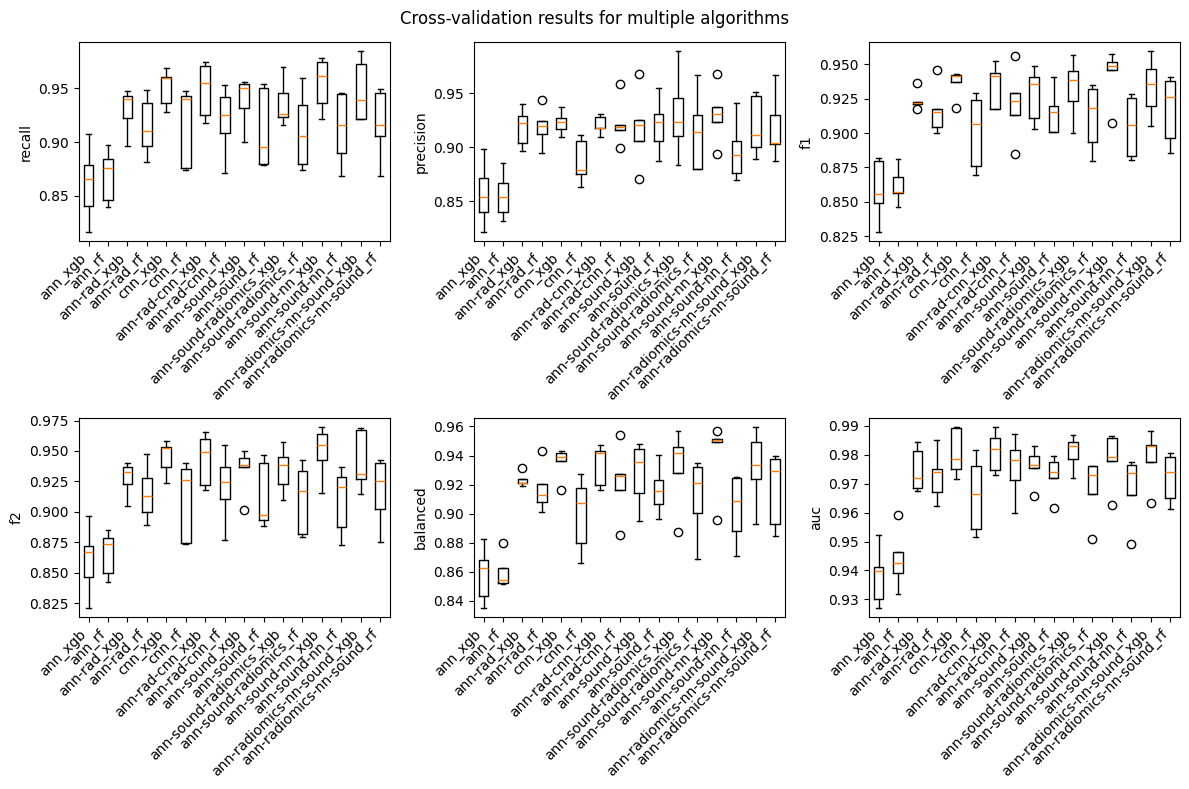

In [47]:
def plot_cv(results_cv, metrics, title="Cross-validation results for multiple algorithms"):
    fig, ax = plt.subplots(2, 3, figsize=(12, 8))
    for i in range(len(metrics)):
        metric = metrics[i]

        ax[i//3, i%3].boxplot(results_cv.filter(regex=metric))
        ax[i//3, i%3].set_xticklabels(["_".join(c.split("_")[:2]) for c in results_cv.filter(regex=metric).columns], rotation=45, ha="right")
        ax[i//3, i%3].set_ylabel(metric.replace(".", "").replace("*", ""))

    fig.suptitle(title)
    plt.tight_layout()
    plt.show()

plot_cv(scores_df, metrics=ann_xgb.columns.values)

We will use statistical tests to determine the best performing models in the validation set. 

In [48]:
def friedman(results_df: pd.DataFrame, alpha=0.05):
    statistic, pvalue = stats.friedmanchisquare(*[results_df[alg] for alg in results_df.columns])
    print(f"p value: {pvalue:.4f}")

    if pvalue > alpha:
        print("Probably the same distribution")
    else:
        print("Probably different distributions")

    return sp.posthoc_nemenyi_friedman(results_df)


print("Recall:")
paired_comp_recall = friedman(scores_df.filter(like="recall"))
print()
print("Precision:")
paired_comp_precision  = friedman(scores_df.filter(like="precision"))
print()
print("F1 Score:")
paired_comp_f1 = friedman(scores_df.filter(like="f1"))
print()
print("F2 Score:")
paired_comp_f2 = friedman(scores_df.filter(like="f2"))
print()
print("Balanced:")
paired_comp_acc  = friedman(scores_df.filter(like="balanced"))
print()
print("AUC Score:")
paired_comp_auc = friedman(scores_df.filter(like="auc"))

Recall:
p value: 0.000096
Probably different distributions

Precision:
p value: 0.001226
Probably different distributions

F1 Score:
p value: 0.000083
Probably different distributions

F2 Score:
p value: 0.000093
Probably different distributions

Balanced:
p value: 0.000183
Probably different distributions

AUC Score:
p value: 0.000592
Probably different distributions


These matrix provides a post-hoc analysis for all metrics across multiple models. The colors represent the significance levels of pairwise comparisons, helping us identify which models have statistically significant differences.

### Analysis:

1. **Significance Levels**:
   - **Dark Green (p < 0.001)**: This indicates a very high level of statistical significance. Models with comparisons marked in dark green have values that are very significantly different.
   - **Medium Green (p < 0.01)**: This represents a high level of significance but slightly less strict than p < 0.001.
   - **Light Green (p < 0.05)**: This indicates a mild level of significance. While there is a statistically significant difference, it is less robust than the previous two levels.
   - **Pink (NS - Not Significant)**: These cells indicate that the models are not significantly different in recall performance.

2. **Interpretation**:
   - Comparisons with **significant differences** (p < 0.05, p < 0.01, p < 0.001) are valuable for identifying which models outperform others. For example, cells with dark green (p < 0.001) suggest that the models in comparison have notably different scores, making it clear that one model is statistically superior.
   - **Non-significant (NS)** comparisons, shown in pink, indicate that the models perform similarly. Choosing between these models might then depend on other metrics or factors, as one metric alone does not differentiate them significantly.

3. **Model Clustering**:
   - Models clustered with NS cells (pink) are statistically similar. This similarity suggests these models are interchangeable in performance, allowing for flexibility in selection based on other criteria (such as computational efficiency, or ease of implementation).
   - The presence of dark green cells between some models (e.g., around `ann-sound-nn_xgb` and other models) shows that `ann-sound-nn_xgb` might have substantially different (likely higher) performance than some other models.

#### Key Takeaways:
- The **`ann-sound-nn_xgb`** model appears to have statistically significant differences from other models, which suggests it is among the better-performing models in multiple metrics.
- Models with NS (not significant) comparisons are performing similarly, meaning that the choice between these models could be made based on other performance metrics or operational considerations.
- To select the best model, it would be wise to prioritize those with high and significant differences from others, especially if the application demands high sensitivity in detecting malignant nodules, which it does.

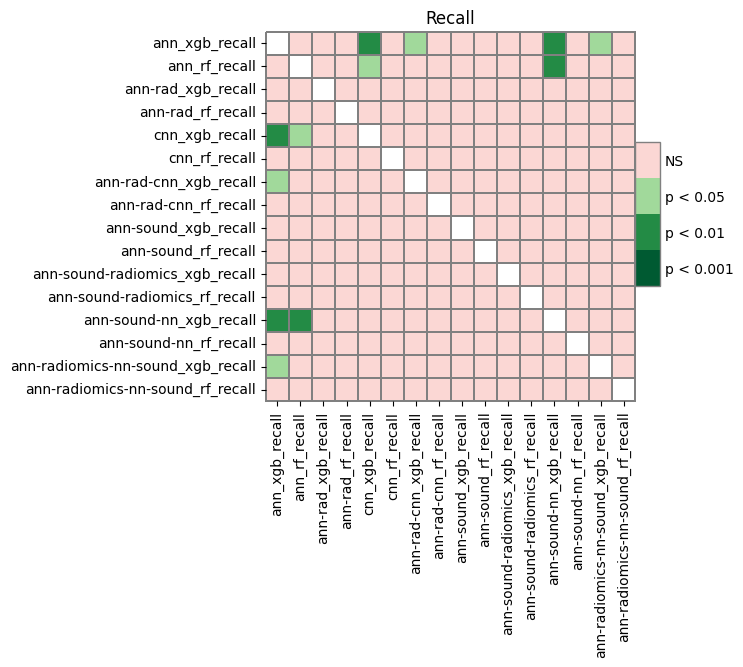

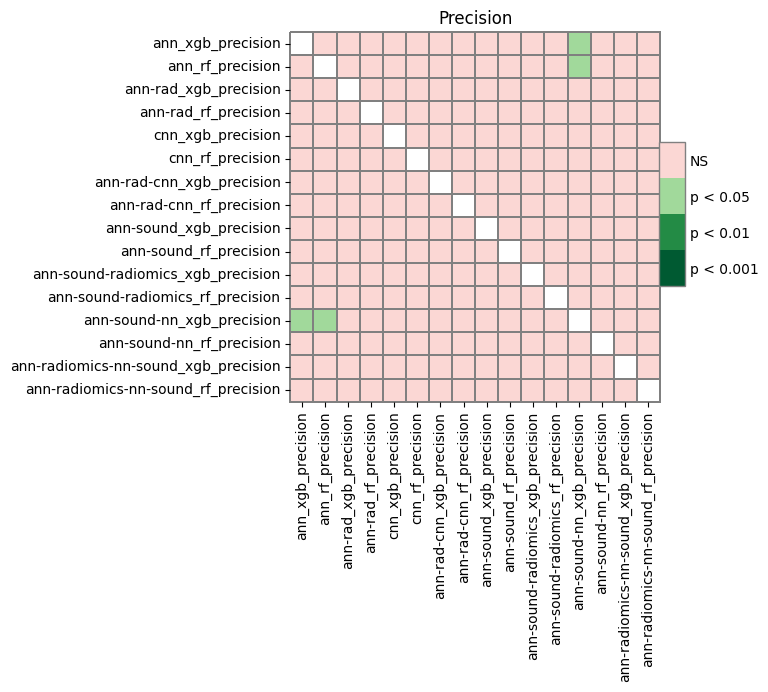

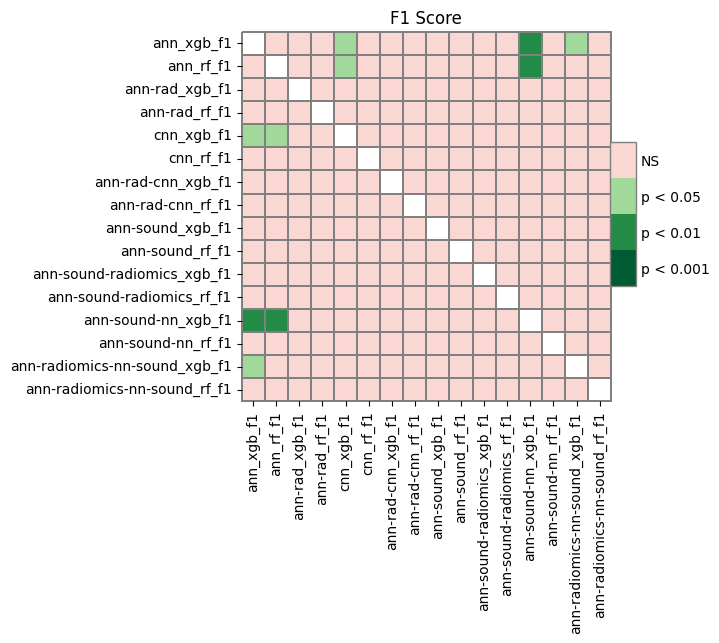

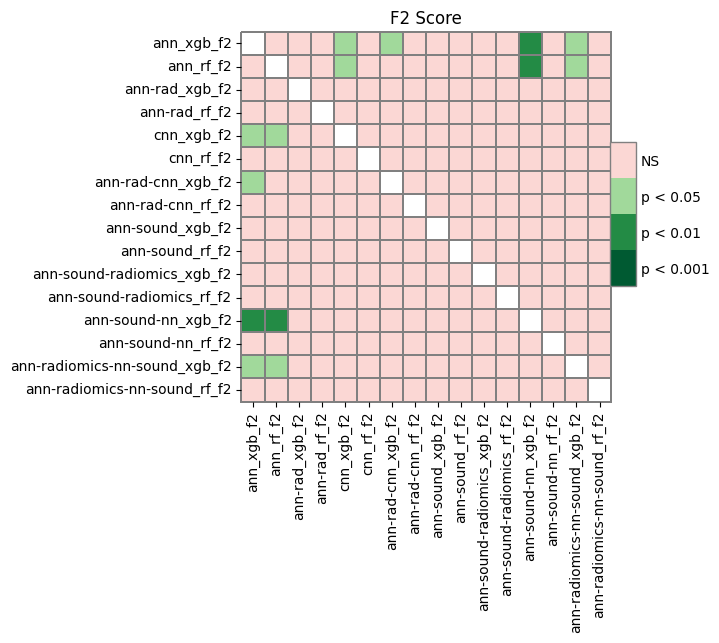

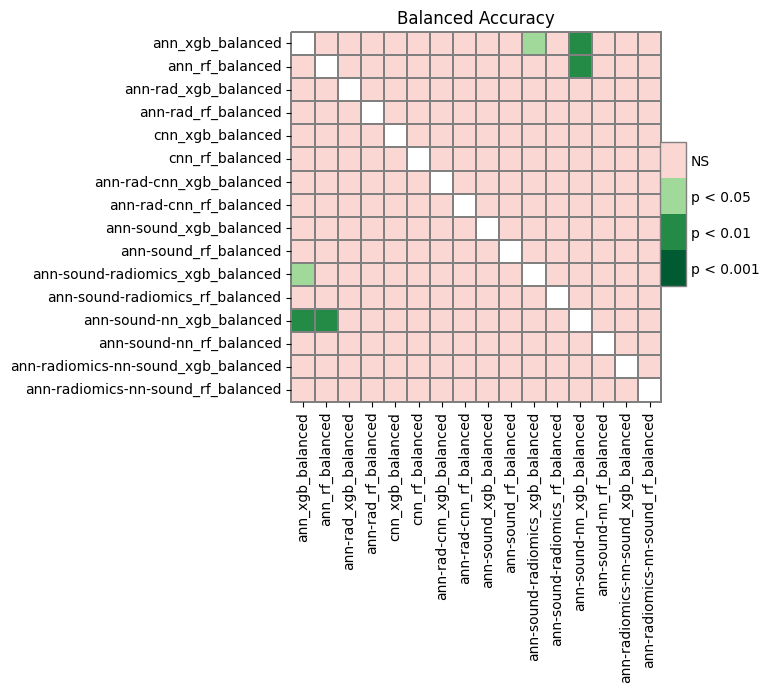

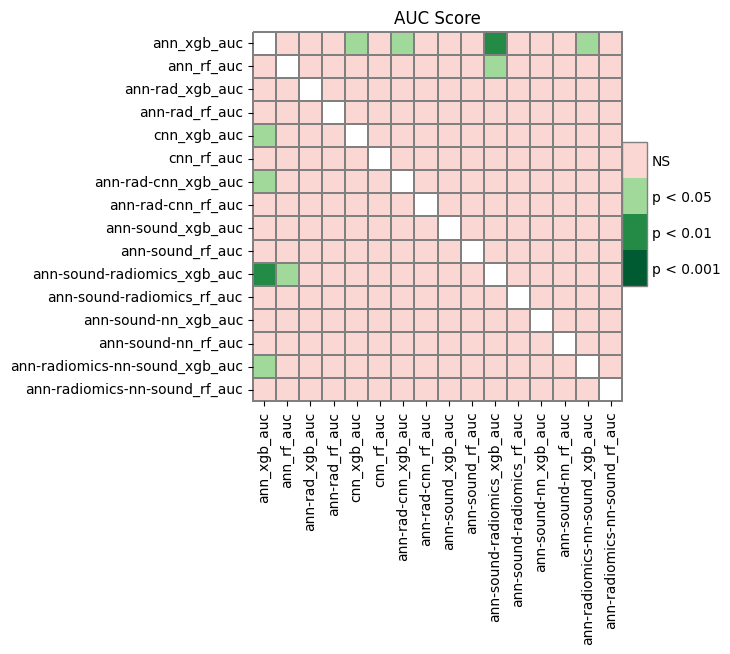

In [49]:
def plot_multiple_comp(paired_comp, title=""):
    plt.subplot()
    plt.title(title)

    # Generate a custom diverging colormap
    # cmap = sns.diverging_palette(230, 20, as_cmap=True)
    heatmap_args = {'linewidths': 0.25, 'linecolor': '0.5',\
    'clip_on': False, 'square': True, \
    'cbar_ax_bbox': [0.80, 0.35, 0.04, 0.3]}
    sp.sign_plot(paired_comp, **heatmap_args)

values = [
    (paired_comp_recall, "Recall"),
    (paired_comp_precision, "Precision"),
    (paired_comp_f1, "F1 Score"),
    (paired_comp_f2, "F2 Score"),
    (paired_comp_acc, "Balanced Accuracy"),
    (paired_comp_auc, "AUC Score"),
]

for v, name in values:
    plot_multiple_comp(v, name)
    plt.show()

These critical difference diagrams illustrate the comparison of scores across various machine learning models, with models that are statistically similar in performance connected by horizontal lines.

We will focus our attention on the recall.

### Key Observations:

1. **Model Grouping by Performance**: 
   - Models on the left side, such as `ann_xgb_recall` and `ann_rf_recall`, have lower recall scores. This positioning indicates that these models are less effective at correctly identifying malignant nodules (i.e., they may have a higher rate of false negatives).
   - Models toward the right, such as `ann-sound-nn_xgb_recall`, `cnn_xgb_recall`, and `ann-rad-cnn_xgb_recall`, have higher recall scores, which suggests they are better at correctly identifying malignant cases, potentially reducing false negatives.

2. **Statistical Differences**:
   - Models connected by a horizontal line are not statistically different in terms of recall. For example, `cnn_xgb_recall` and `ann-rad-cnn_xgb_recall` are connected, implying similar recall performance.
   - This lack of statistical difference means that selecting between models within these connected groups would not significantly impact recall but may allow room for prioritizing other factors, such as computation time or ease of implementation.

3. **Top Performers**:
   - The highest-ranking models, such as `ann-sound-nn_xgb_recall` (0.91), `cnn_xgb_recall` (0.82), and `ann-rad-cnn_xgb_recall` (0.78), are on the right. These models likely provide the best recall performance and would be preferred if maximizing sensitivity to malignant nodules is a priority.
   - These models also form a group, indicating that the differences in recall between them are not statistically significant, meaning any one of them could be a viable choice for prioritizing recall.

4. **Underperformers**:
   - Models like `ann_xgb_recall` and `ann_rf_recall` on the far left have lower recall scores, meaning they may miss more malignant nodules compared to higher-ranked models. They might be more suitable in cases where other metrics (like precision) are prioritized over recall.

### Summary
For applications where maximizing recall is essential (e.g., ensuring all malignant nodules are detected), the models on the right of the diagram (`ann-sound-nn_xgb_recall`, `cnn_xgb_recall`, `ann-rad-cnn_xgb_recall`) are the best choices. These models are not significantly different in recall performance, so choosing among them could depend on additional factors like computational efficiency or interpretability.


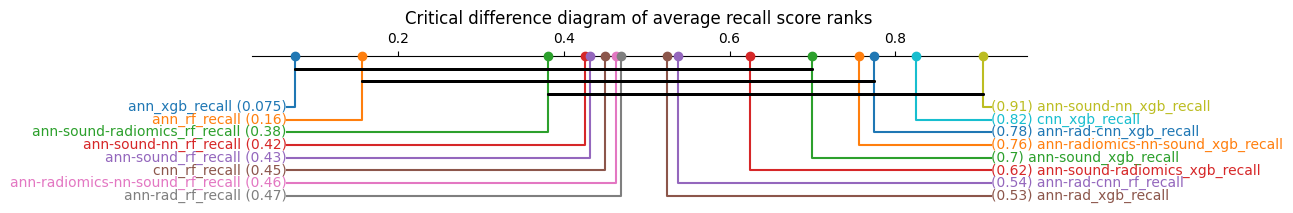

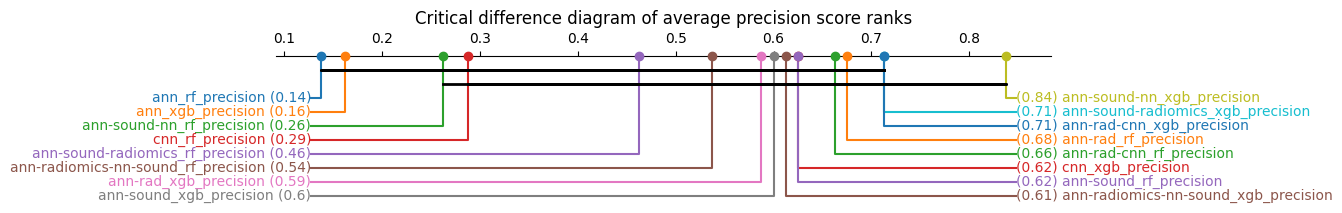

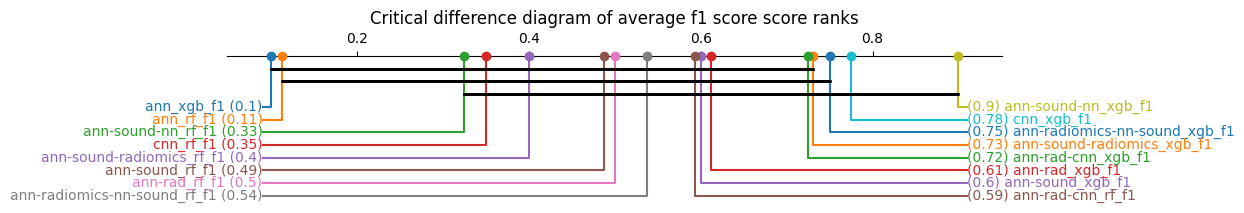

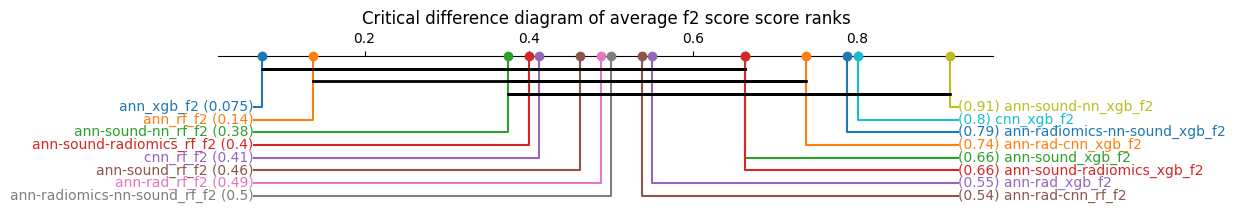

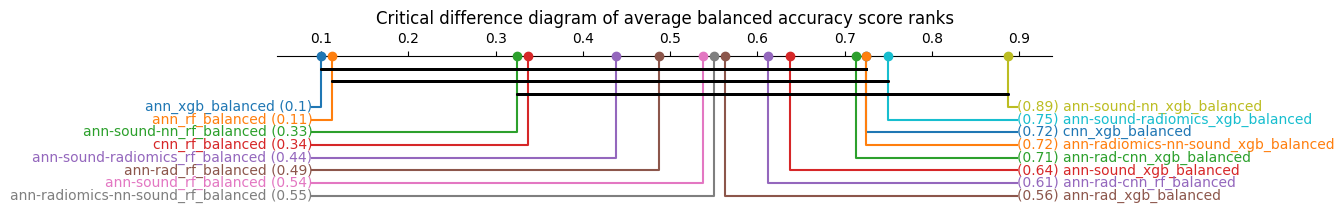

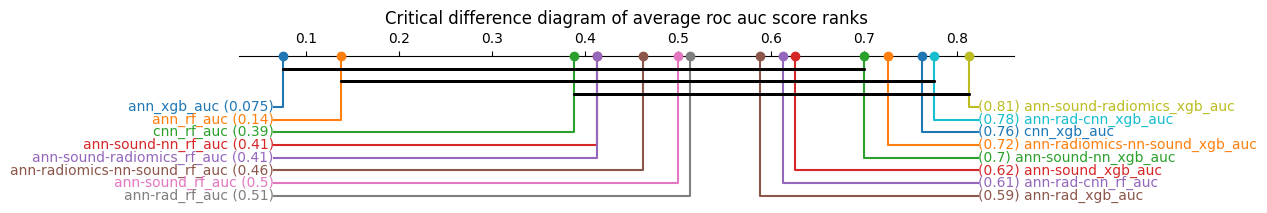

In [50]:
def critical_difference_diagram(df: pd.DataFrame, test_results, metric="metric"):
    data = (
        df.rename_axis('cv_fold')
          .melt(
              var_name='estimator',
              value_name='score',
              ignore_index=False,
          )
          .reset_index()
    )
    avg_rank = data.groupby('cv_fold').score.rank(pct=True).groupby(data.estimator).mean()

    plt.figure(figsize=(10, 2), dpi=100)
    plt.title(f'Critical difference diagram of average {metric} score ranks')
    sp.critical_difference_diagram(avg_rank, test_results)

critical_difference_diagram(scores_df.filter(like="recall"), paired_comp_recall, "recall")
plt.show()

critical_difference_diagram(scores_df.filter(like="precision"), paired_comp_precision, "precision")
plt.show()

critical_difference_diagram(scores_df.filter(like="f1"), paired_comp_f1, "f1 score")
plt.show()

critical_difference_diagram(scores_df.filter(like="f2"), paired_comp_f2, "f2 score")
plt.show()

critical_difference_diagram(scores_df.filter(like="balanced"), paired_comp_acc, "balanced accuracy")
plt.show()

critical_difference_diagram(scores_df.filter(like="auc"), paired_comp_auc, "roc auc")
plt.show()

---

## Discussion and Conclusions

if the solution serves the business purpose, its applicability and impact?

- while the results are promissing they are not as precise as they should be for the importance of the subject at hand
- the ideia behind this project is to aid doctors in their diagonostics to not only increasse the certainty but also to avoid more evasive and expensive methods
- some interesting finding to note are that, radiomics is always amongs the most important features and that, amongs the top 5 values, there is no one that particularlly stands out 


Future work:

- elaborate on sound because the results were promissing 
- use annotations with malignancy 5 directly without doing consensus with other radiologists to increase the number of positive samples
- if possible to change contrasts of resonances to see blood vessels, use and elongated version of the 25% consent mask and use the image originated from that to get more information regarding the nodule


---

## References

- [1] Cellina, M., Cacioppa, L.M., Cè, M., Chiarpenello, V., Costa, M., Vincenzo, Z., Pais, D., Bausano, M.V., Rossini, N., Bruno, A. and Floridi, C. (2023). Artificial Intelligence in Lung Cancer Screening: The Future Is Now. Cancers, [online] 15(17), p.4344. doi:https://doi.org/10.3390/cancers15174344.

- [2] Lv, E., Liu, W., Wen, P. and Kang, X. (2021). Classification of Benign and Malignant Lung Nodules Based on Deep Convolutional Network Feature Extraction. Journal of Healthcare Engineering, 2021, pp.1–11. doi:https://doi.org/10.1155/2021/8769652.

- [3] Lee, G., Park, H., Bak, S.H. and Lee, H.Y. (2020). Radiomics in Lung Cancer from Basic to Advanced: Current Status and Future Directions. Korean Journal of Radiology, 21(2), p.159. doi:https://doi.org/10.3348/kjr.2019.0630.

- [4] Causey, J.L., Zhang, J., Ma, S., Jiang, B., Qualls, J.A., Politte, D.G., Prior, F., Zhang, S. and Huang, X. (2018). Highly accurate model for prediction of lung nodule malignancy with CT scans. Scientific Reports, 8(1). doi:https://doi.org/10.1038/s41598-018-27569-w.

- [5] Bhattacharjee, A., Sameh Rabea, Bhattacharjee, A., Elkaeed, E.B., R. Murugan, Refat, M., Ram Kumar Sahu, Shazly, G.A. and Salem, M. (2023). A multi-class deep learning model for early lung cancer and chronic kidney disease detection using computed tomography images. Frontiers in oncology, 13. doi:https://doi.org/10.3389/fonc.2023.1193746.

- Github.io. (2018). Scan — pylidc  documentation. [online] Available at: https://pylidc.github.io/scan.html [Accessed 15 Oct. 2024].

- washingtongold (2022). Loading and Reading LIDC-IDRI. [online] Kaggle.com. Available at: https://www.kaggle.com/code/washingtongold/loading-and-reading-lidc-idri [Accessed 2 Nov. 2024].

- MIC-DKFZ (2018). LIDC-IDRI-processing/lidc_data_to_nifti.py at master · MIC-DKFZ/LIDC-IDRI-processing. [online] GitHub. Available at: https://github.com/MIC-DKFZ/LIDC-IDRI-processing/blob/master/lidc_data_to_nifti.py [Accessed 2 Nov. 2024].
